# Optimizer comparison
This notebook runs the same standard model, just using 3 different optimizers(SGD, Adam, AdamW) to see which improves the model performance the most. The results are interpreted/summarized at the end of the notebook.


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rnapark","key":"f766d3a80003b91cb04f4e4633ffd077"}'}

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets list

ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025                Spotify Global Music Dataset (2009–2025)               1289021  2025-11-11 09:43:05.933000           5651        115  1.0              
sadiajavedd/students-academic-performance-dataset               Students_Academic_Performance_Dataset                     8907  2025-10-23 04:16:35.563000          11304        281  1.0              
prince7489/food-delivery-route-efficiency-dataset               Food Delivery Route Efficiency Dataset                    4082  2025-11-19 14:07:34.733000           1206         25  0.9411765        


In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

plant_pathology_2020_fgvc7_path = kagglehub.competition_download('plant-pathology-2020-fgvc7')
rnapark_resnet18_f37072fd_pth_path = kagglehub.dataset_download('rnapark/resnet18-f37072fd-pth')
rnapark_resnet34_b627a593_pth_path = kagglehub.dataset_download('rnapark/resnet34-b627a593-pth')

print('Data source import complete.')


100%|██████████| 779M/779M [00:04<00:00, 200MB/s]

Extracting files...


100%|██████████| 41.4M/41.4M [00:00<00:00, 120MB/s]

Extracting files...


100%|██████████| 77.2M/77.2M [00:00<00:00, 101MB/s] 

Extracting files...


Data source import complete.


# Load data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image
import os

class AppleDataset(Dataset):
  def __init__(self, csv_path, images, transform=None, is_test=False):
    self.data = pd.read_csv(csv_path)
    self.images = images
    self.transform = transform
    self.is_test = is_test

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    row = self.data.iloc[idx]
    image_path = os.path.join(self.images, row['image_id']+".jpg")
    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)

    if self.is_test:
      return image
    else:
      label = row[['healthy', 'multiple_diseases', 'rust', 'scab']].values.astype("float32")
      return image, label


# Input data files are available in the read-only "../input/" directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# file paths
base_dir = plant_pathology_2020_fgvc7_path
train_csv = base_dir + "/train.csv"
test_csv  = base_dir + "/test.csv"
images = base_dir + "/images"

train_data = AppleDataset(train_csv, images, transform=None)
test_data  = AppleDataset(test_csv, images, transform=None, is_test=True)

# Commented out the below because transforms are not defined until later
# train_set, val_set = random_split(train_data, [0.8, 0.2])

# # Prepare DataLoaders
# train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# print("Data loaded successfully!")
# print("Train batches:", len(train_loader))
# print("Val batches:", len(val_loader))
# print("Test batches:", len(test_loader))

# images, labels = next(iter(train_loader))
# print(images.shape)  # (64, 3, H, W)
# print(labels.shape)  # (64, 4)


## Helper to visualize training curves

In [ ]:
from matplotlib import pyplot as plt

# Helper function to visualize performance during training
def plot_training_curves(train_losses, val_accuracies):
    """Plot training loss and validation accuracy curves.

    Parameters
    ----------
    train_losses : list of float
        Training loss values for each epoch. Should have one value per epoch.
    val_accuracies : list of float
        Validation accuracy values for each epoch. Should have same length as
        train_losses. Accuracy values should be between 0 and 1 (or 0 and 100
        if using percentages).

    Returns
    -------
    None
        Displays matplotlib figure with two subplots showing training curves.

    Examples
    --------
    >>> train_losses = [0.8, 0.6, 0.4, 0.3, 0.2]
    >>> val_accuracies = [0.75, 0.80, 0.85, 0.87, 0.88]
    >>> plot_training_curves(train_losses, val_accuracies)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(val_accuracies)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Define training loop, evaluation loop

In [ ]:
# Define train/test loop

def mixup_data(x, y, alpha=0.2):
    # Returns mixed inputs, pairs of targets, and lambda
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def train_loop(
        dataloader,
        model,
        loss_fn,
        optimizer,
        device,
        smoothing=0.02,
        grad_clip=1.0,
        use_mixup=True,
        mixup_alpha=0.2
    ):

    model.train()
    total_loss = 0.0

    for X, y in dataloader:
        X = X.to(device)
        y = y.float().to(device)
        y_smooth = y * (1 - smoothing) + (1 - y) * smoothing

        # MixUp augmentation
        if use_mixup:
            X, y_a, y_b, lam = mixup_data(X, y_smooth, alpha=mixup_alpha)

            # Apply label smoothing AFTER mixup
            y_a = y_a * (1 - smoothing) + (1 - y_a) * smoothing
            y_b = y_b * (1 - smoothing) + (1 - y_b) * smoothing

            pred = model(X)
            loss = lam * loss_fn(pred, y_a) + (1 - lam) * loss_fn(pred, y_b)
        else:
            # Only smoothing if NOT using mixup
            y_smooth = y * (1 - smoothing) + (1 - y) * smoothing
            pred = model(X)
            loss = loss_fn(pred, y_smooth)

        optimizer.zero_grad()
        loss.backward()

        # gradient clipping
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)
def evaluate_model(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct_predictions_sum = 0, 0
    num_labels = 4 # Number of output labels in our dataset

    model.eval()
    with torch.no_grad():
      for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X) # These are logits
        test_loss += loss_fn(pred, y).item()

        # Apply sigmoid to logits to get probabilities
        probabilities = torch.sigmoid(pred)
        # Threshold probabilities to get binary predictions (0 or 1)
        predicted_labels = (probabilities > 0.5).float()
        # Count total correct individual label predictions (TP + TN)
        correct_predictions_sum += (predicted_labels == y).float().sum().item()

    test_loss = test_loss / num_batches
    # Calculate overall accuracy as the ratio of correctly predicted individual labels
    # to the total possible individual labels (num_samples * num_labels)
    total_possible_labels = size * num_labels
    accuracy = correct_predictions_sum / total_possible_labels
    return test_loss, accuracy

def predict_loop(loader, model, device):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Raw probabilities for each class

            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())

    return torch.cat(all_labels, dim=0), torch.cat(all_probs, dim=0)

def predict_test_loop(loader, model, device):
    model.eval()
    all_probs = []

    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (list, tuple)):
                images = batch[0]
            else:
                images = batch

            images = images.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Raw probabilities

            all_probs.append(probs.cpu())

    return torch.cat(all_probs, dim=0)


# Improving model with fine tuning

In [ ]:
def apply_thresholding(probs, thresholds):
    """
    Apply thresholds to the predicted probabilities.
    Args:
    - probs: The predicted probabilities for each class (shape: [batch_size, num_classes])
    - thresholds: The threshold value for each class (shape: [num_classes])

    Returns:
    - preds: The predicted class labels after applying thresholds (shape: [batch_size, num_classes])
    """
    # Initialize an array to store the predictions for each sample
    preds = torch.zeros_like(probs, dtype=torch.long)

    for i in range(probs.shape[0]):  # Iterate over each sample in the batch
        for c in range(probs.shape[1]):  # Iterate over each class
            if probs[i, c] > thresholds[c]:  # Check if the probability exceeds the threshold
                preds[i, c] = 1  # Set the class prediction to 1 (indicating the class is selected)

    # For each sample, choose the class with the maximum probability if no class exceeds threshold
    preds = torch.argmax(probs, dim=1)  # Use the highest probability class if no threshold is surpassed

    return preds

## Defining visualizations for evaluation

In [ ]:
# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, roc_auc_score, precision_recall_fscore_support

def plot_confusion_matrix(y_true, y_pred, class_names):
    # Generate a confusion matrix for each class in a one-vs-rest manner
    for i, class_name in enumerate(class_names):
        # For each class, consider it as positive and all others as negative
        true_labels = y_true[:, i]
        pred_labels = y_pred[:, i]
        cm = confusion_matrix(true_labels, pred_labels)

        # Extract metrics
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0) # Handle cases where a class might not be present
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        print(f"\nMetrics for class: {class_name}")
        print(f"  True Positives (TP): {tp}")
        print(f"  False Positives (FP): {fp}")
        print(f"  False Negatives (FN): {fn}")
        print(f"  True Negatives (TN): {tn}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")

        # Calculate and print F1-score
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        print(f"  F1-score: {f1_score:.4f}")

        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=[f'Not {class_name}', class_name],
                    yticklabels=[f'Not {class_name}', class_name])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix for {class_name}')
        plt.show()

def plot_precision_recall_curve(y_true, y_pred, class_names):
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        plt.plot(recall, precision, label=f'{class_names[i]}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

def plot_roc_curve(y_true, y_pred, class_names):
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()


TESTING OPTIMIZER: SGD


----- Fold 1 / 5 (Optimizer: SGD) -----
Epoch 1/15
Train Loss: 1.1404 | Val Loss: 0.9614 | Val Acc: 0.5877
Epoch 2/15
Train Loss: 1.0059 | Val Loss: 0.7256 | Val Acc: 0.7123
Epoch 3/15
Train Loss: 0.8387 | Val Loss: 0.5498 | Val Acc: 0.7390
Epoch 4/15
Train Loss: 0.7500 | Val Loss: 0.4574 | Val Acc: 0.8534
Epoch 5/15
Train Loss: 0.7083 | Val Loss: 0.4026 | Val Acc: 0.8925
Epoch 6/15
Train Loss: 0.6813 | Val Loss: 0.4058 | Val Acc: 0.8863
Epoch 7/15
Train Loss: 0.7231 | Val Loss: 0.4560 | Val Acc: 0.8473
Epoch 8/15
Train Loss: 0.7206 | Val Loss: 0.4094 | Val Acc: 0.8781
Epoch 9/15
Train Loss: 0.7020 | Val Loss: 0.4139 | Val Acc: 0.8781
Epoch 10/15
Train Loss: 0.6717 | Val Loss: 0.3847 | Val Acc: 0.8801
Epoch 11/15
Train Loss: 0.6738 | Val Loss: 0.3762 | Val Acc: 0.8575
Epoch 12/15
Train Loss: 0.6796 | Val Loss: 0.3700 | Val Acc: 0.9151
Epoch 13/15
Train Loss: 0.6724 | Val Loss: 0.3951 | Val Acc: 0.9062
Epoch 14/15
Train Loss: 0.5974 | Val Loss: 0.3786 | Val Acc

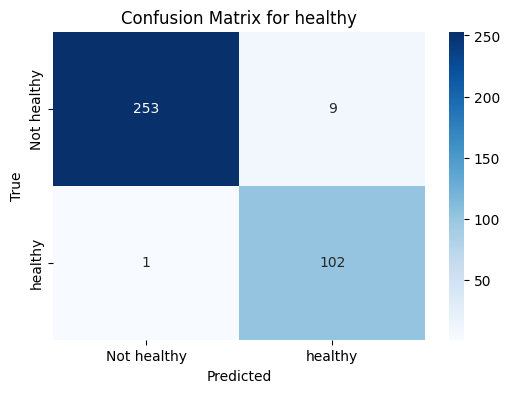


Metrics for class: multiple_diseases
  True Positives (TP): 12
  False Positives (FP): 38
  False Negatives (FN): 6
  True Negatives (TN): 309
  Precision: 0.2400
  Recall: 0.6667
  F1-score: 0.3529


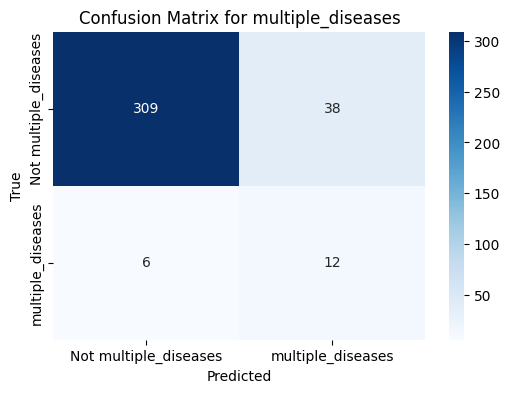


Metrics for class: rust
  True Positives (TP): 123
  False Positives (FP): 10
  False Negatives (FN): 2
  True Negatives (TN): 230
  Precision: 0.9248
  Recall: 0.9840
  F1-score: 0.9535


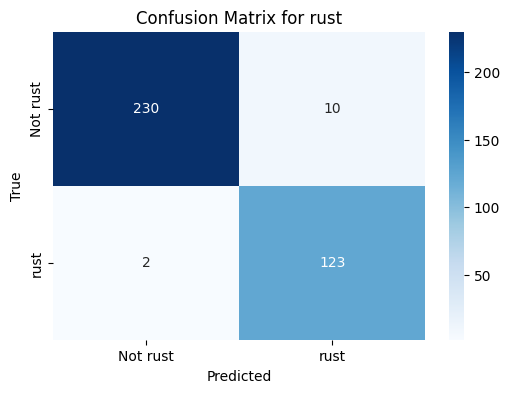


Metrics for class: scab
  True Positives (TP): 116
  False Positives (FP): 6
  False Negatives (FN): 3
  True Negatives (TN): 240
  Precision: 0.9508
  Recall: 0.9748
  F1-score: 0.9627


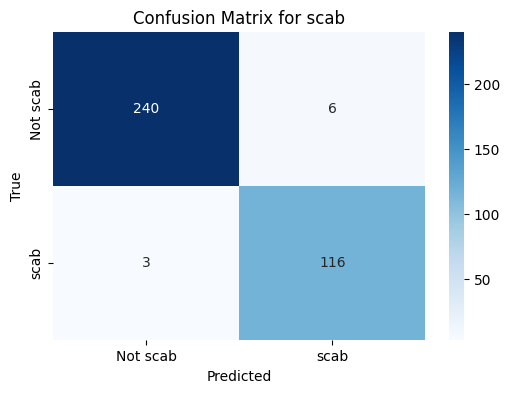

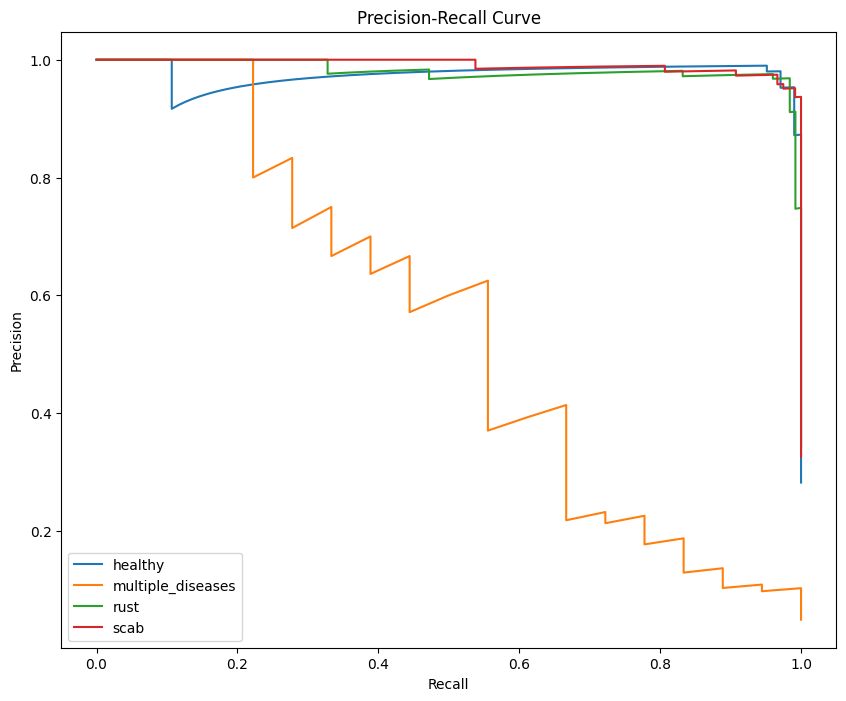

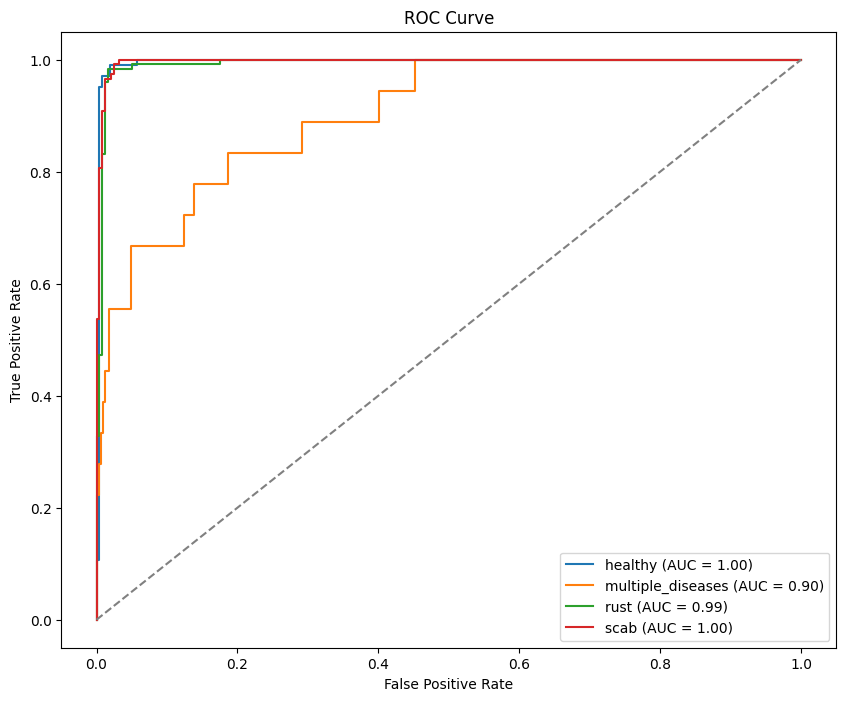


----- Fold 2 / 5 (Optimizer: SGD) -----
Epoch 1/15
Train Loss: 1.1225 | Val Loss: 0.9407 | Val Acc: 0.6078
Epoch 2/15
Train Loss: 0.9708 | Val Loss: 0.6855 | Val Acc: 0.6813
Epoch 3/15
Train Loss: 0.7778 | Val Loss: 0.4884 | Val Acc: 0.7589
Epoch 4/15
Train Loss: 0.7074 | Val Loss: 0.4194 | Val Acc: 0.8132
Epoch 5/15
Train Loss: 0.7439 | Val Loss: 0.4200 | Val Acc: 0.9265
Epoch 6/15
Train Loss: 0.6660 | Val Loss: 0.4203 | Val Acc: 0.8104
Epoch 7/15
Train Loss: 0.6307 | Val Loss: 0.4033 | Val Acc: 0.8709
Epoch 8/15
Train Loss: 0.6898 | Val Loss: 0.4358 | Val Acc: 0.8592
Epoch 9/15
Train Loss: 0.6546 | Val Loss: 0.3773 | Val Acc: 0.9203
Epoch 10/15
Train Loss: 0.6188 | Val Loss: 0.3615 | Val Acc: 0.9334
Epoch 11/15
Train Loss: 0.6182 | Val Loss: 0.4061 | Val Acc: 0.8764
Epoch 12/15
Train Loss: 0.6515 | Val Loss: 0.4009 | Val Acc: 0.9375
Epoch 13/15
Train Loss: 0.6749 | Val Loss: 0.4313 | Val Acc: 0.8036
Epoch 14/15
Train Loss: 0.6056 | Val Loss: 0.4310 | Val Acc: 0.8510
Epoch 15/15
Trai

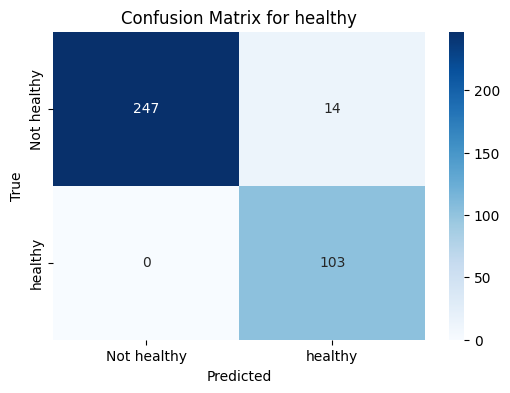


Metrics for class: multiple_diseases
  True Positives (TP): 9
  False Positives (FP): 31
  False Negatives (FN): 9
  True Negatives (TN): 315
  Precision: 0.2250
  Recall: 0.5000
  F1-score: 0.3103


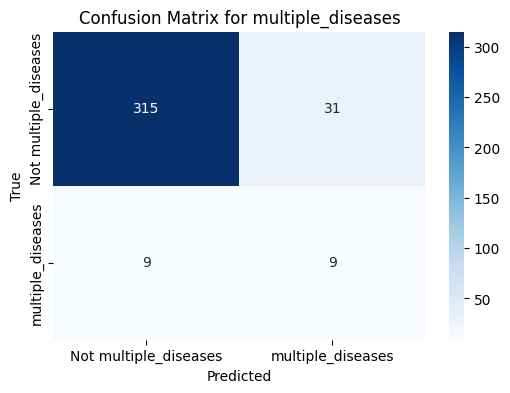


Metrics for class: rust
  True Positives (TP): 121
  False Positives (FP): 2
  False Negatives (FN): 3
  True Negatives (TN): 238
  Precision: 0.9837
  Recall: 0.9758
  F1-score: 0.9798


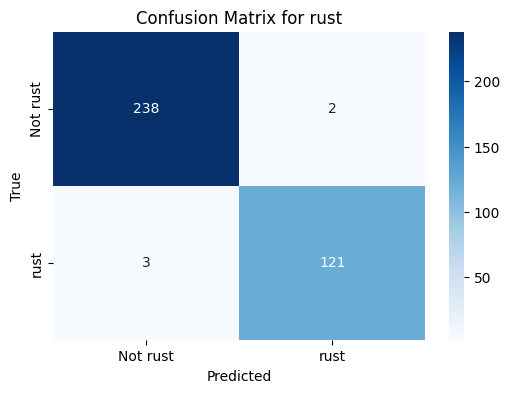


Metrics for class: scab
  True Positives (TP): 115
  False Positives (FP): 10
  False Negatives (FN): 4
  True Negatives (TN): 235
  Precision: 0.9200
  Recall: 0.9664
  F1-score: 0.9426


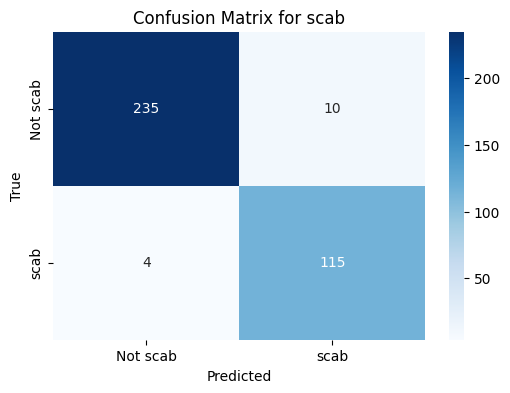

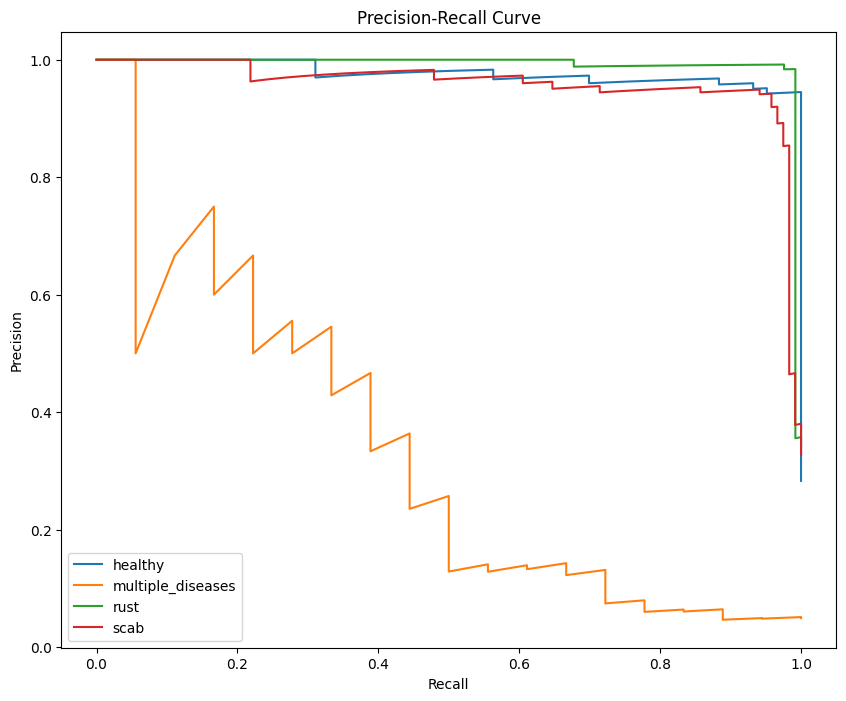

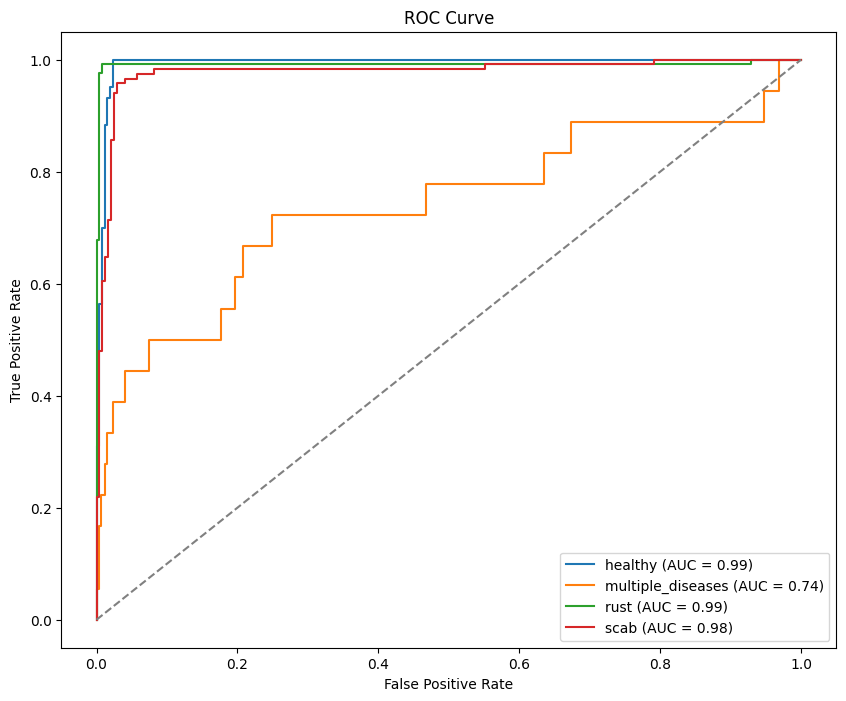


----- Fold 3 / 5 (Optimizer: SGD) -----
Epoch 1/15
Train Loss: 1.1478 | Val Loss: 0.9835 | Val Acc: 0.5604
Epoch 2/15
Train Loss: 1.0138 | Val Loss: 0.7564 | Val Acc: 0.7294
Epoch 3/15
Train Loss: 0.8363 | Val Loss: 0.5419 | Val Acc: 0.7768
Epoch 4/15
Train Loss: 0.7841 | Val Loss: 0.5037 | Val Acc: 0.7720
Epoch 5/15
Train Loss: 0.7645 | Val Loss: 0.4904 | Val Acc: 0.8166
Epoch 6/15
Train Loss: 0.6912 | Val Loss: 0.4225 | Val Acc: 0.8743
Epoch 7/15
Train Loss: 0.6888 | Val Loss: 0.4311 | Val Acc: 0.9073
Epoch 8/15
Train Loss: 0.7428 | Val Loss: 0.4331 | Val Acc: 0.8901
Epoch 9/15
Train Loss: 0.6278 | Val Loss: 0.3932 | Val Acc: 0.8805
Epoch 10/15
Train Loss: 0.6310 | Val Loss: 0.3853 | Val Acc: 0.9492
Epoch 11/15
Train Loss: 0.6333 | Val Loss: 0.3990 | Val Acc: 0.9334
Epoch 12/15
Train Loss: 0.6780 | Val Loss: 0.4473 | Val Acc: 0.8784
Epoch 13/15
Train Loss: 0.6600 | Val Loss: 0.3936 | Val Acc: 0.9402
Epoch 14/15
Train Loss: 0.6540 | Val Loss: 0.3930 | Val Acc: 0.9499
Epoch 15/15
Trai

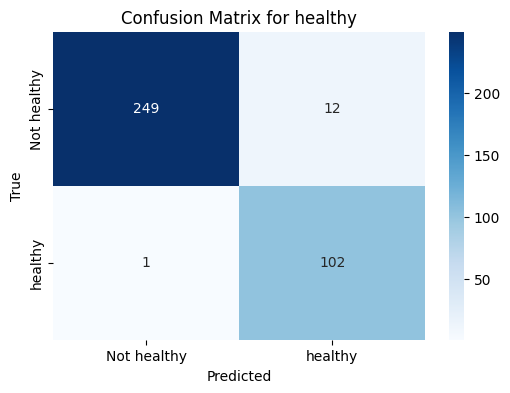


Metrics for class: multiple_diseases
  True Positives (TP): 13
  False Positives (FP): 29
  False Negatives (FN): 6
  True Negatives (TN): 316
  Precision: 0.3095
  Recall: 0.6842
  F1-score: 0.4262


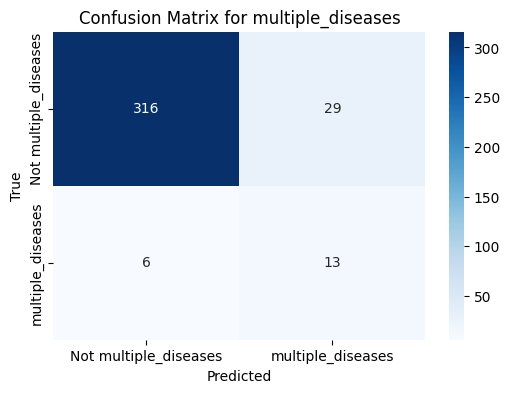


Metrics for class: rust
  True Positives (TP): 124
  False Positives (FP): 6
  False Negatives (FN): 0
  True Negatives (TN): 234
  Precision: 0.9538
  Recall: 1.0000
  F1-score: 0.9764


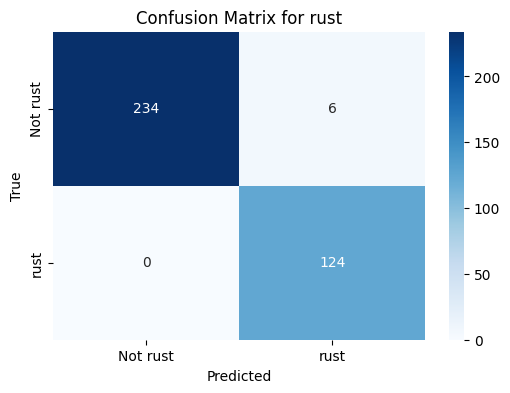


Metrics for class: scab
  True Positives (TP): 115
  False Positives (FP): 9
  False Negatives (FN): 3
  True Negatives (TN): 237
  Precision: 0.9274
  Recall: 0.9746
  F1-score: 0.9504


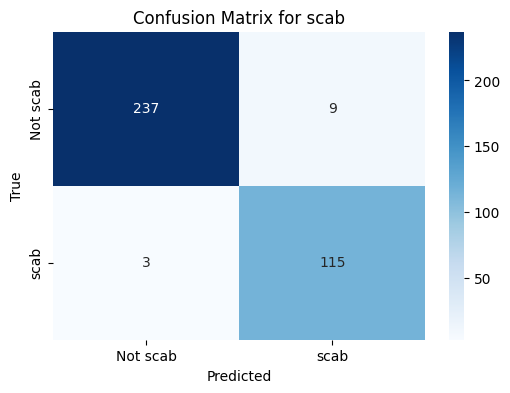

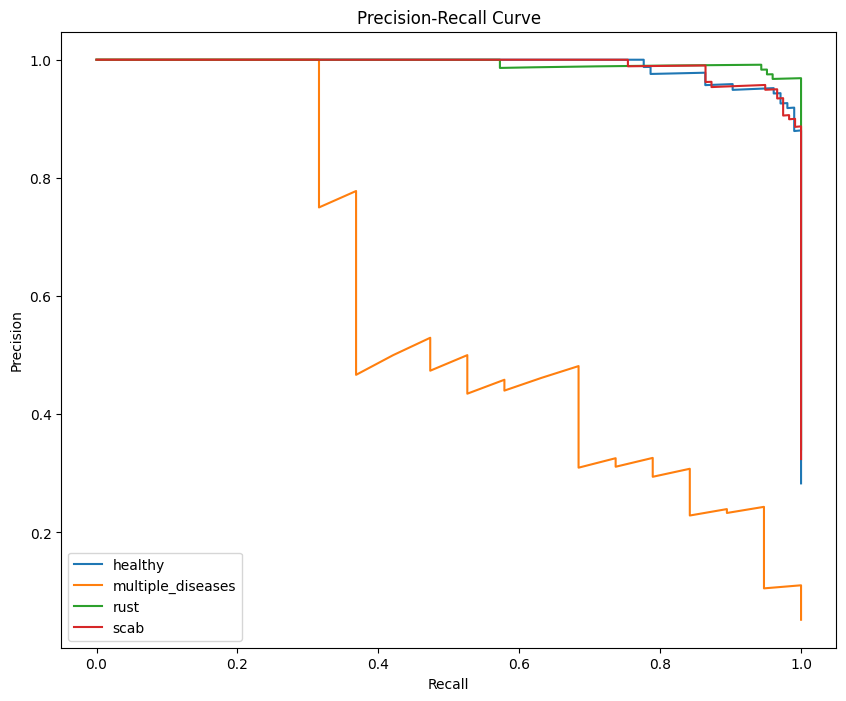

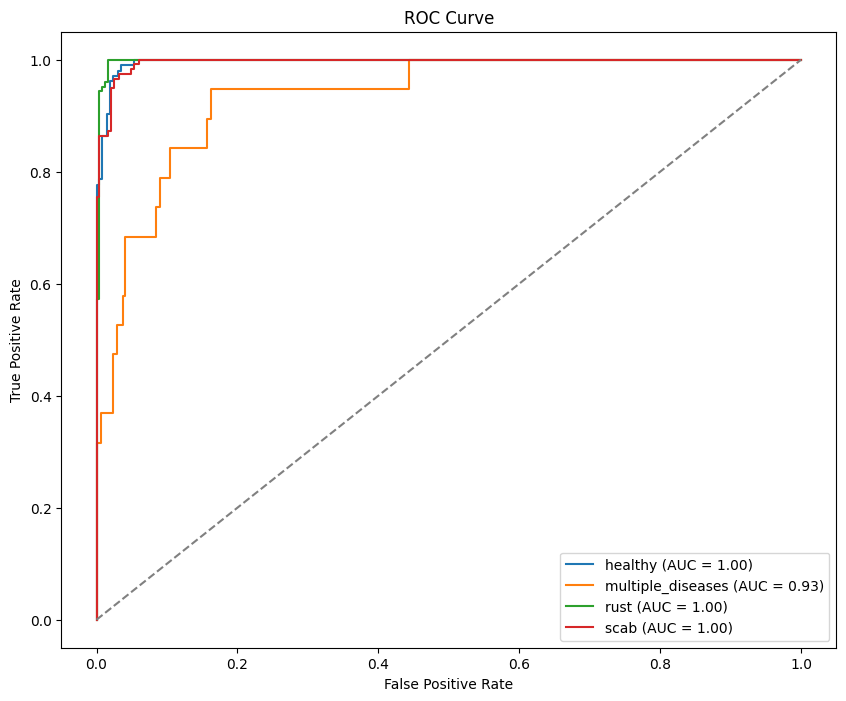


----- Fold 4 / 5 (Optimizer: SGD) -----
Epoch 1/15
Train Loss: 1.1341 | Val Loss: 0.9490 | Val Acc: 0.5694
Epoch 2/15
Train Loss: 0.9788 | Val Loss: 0.7224 | Val Acc: 0.6703
Epoch 3/15
Train Loss: 0.8768 | Val Loss: 0.5206 | Val Acc: 0.8674
Epoch 4/15
Train Loss: 0.7713 | Val Loss: 0.4694 | Val Acc: 0.8091
Epoch 5/15
Train Loss: 0.7470 | Val Loss: 0.4120 | Val Acc: 0.9025
Epoch 6/15
Train Loss: 0.7269 | Val Loss: 0.3691 | Val Acc: 0.8984
Epoch 7/15
Train Loss: 0.7153 | Val Loss: 0.3696 | Val Acc: 0.9313
Epoch 8/15
Train Loss: 0.7803 | Val Loss: 0.4365 | Val Acc: 0.8784
Epoch 9/15
Train Loss: 0.6942 | Val Loss: 0.3748 | Val Acc: 0.9265
Epoch 10/15
Train Loss: 0.6669 | Val Loss: 0.3879 | Val Acc: 0.8846
Epoch 11/15
Train Loss: 0.6937 | Val Loss: 0.4024 | Val Acc: 0.8544
Early stopping triggered.

Classification Report:
                   precision    recall  f1-score   support

          healthy       0.87      1.00      0.93       104
multiple_diseases       0.19      0.83      0.32   

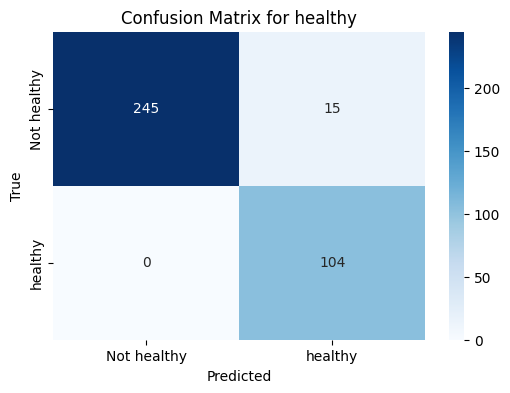


Metrics for class: multiple_diseases
  True Positives (TP): 15
  False Positives (FP): 62
  False Negatives (FN): 3
  True Negatives (TN): 284
  Precision: 0.1948
  Recall: 0.8333
  F1-score: 0.3158


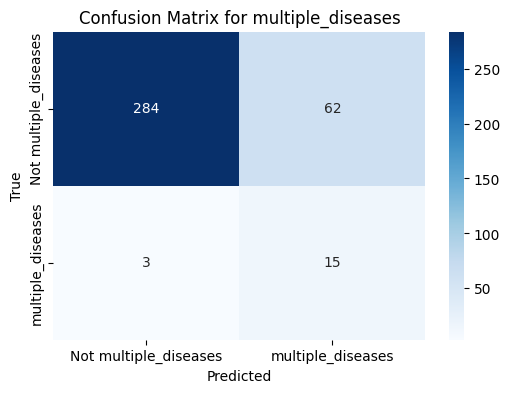


Metrics for class: rust
  True Positives (TP): 124
  False Positives (FP): 8
  False Negatives (FN): 0
  True Negatives (TN): 232
  Precision: 0.9394
  Recall: 1.0000
  F1-score: 0.9688


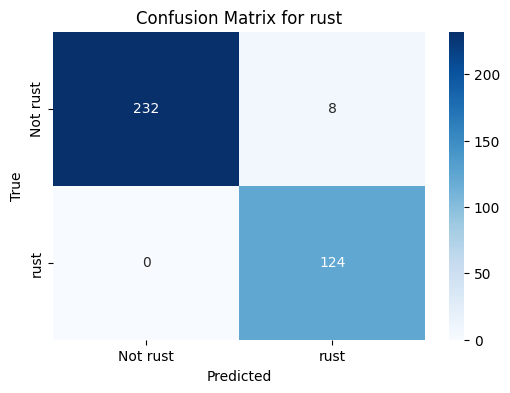


Metrics for class: scab
  True Positives (TP): 112
  False Positives (FP): 3
  False Negatives (FN): 6
  True Negatives (TN): 243
  Precision: 0.9739
  Recall: 0.9492
  F1-score: 0.9614


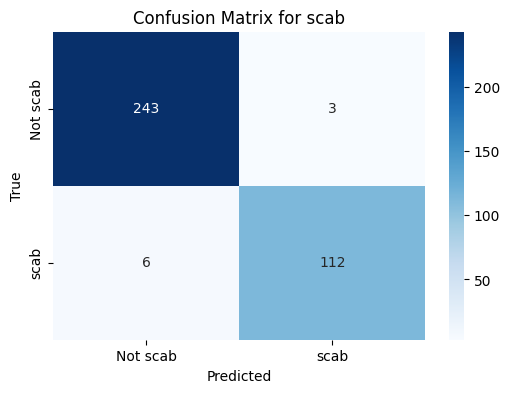

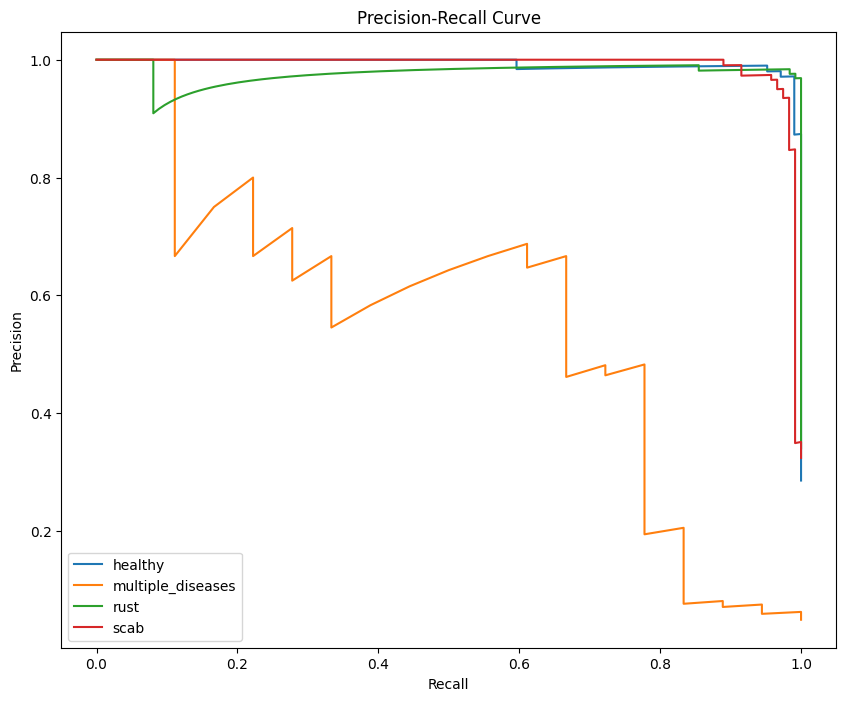

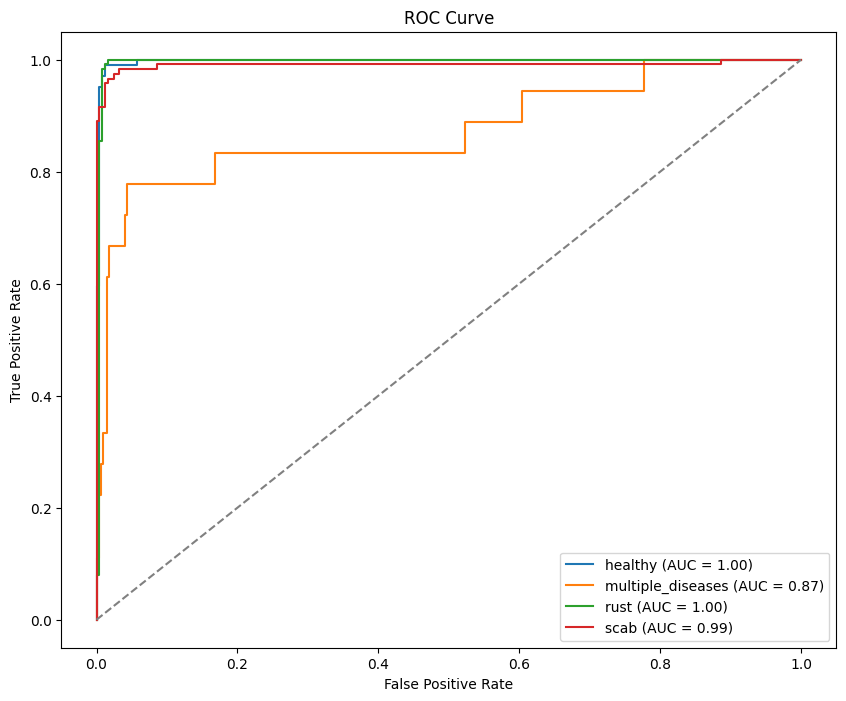


----- Fold 5 / 5 (Optimizer: SGD) -----
Epoch 1/15
Train Loss: 1.1533 | Val Loss: 0.9680 | Val Acc: 0.5302
Epoch 2/15
Train Loss: 0.9960 | Val Loss: 0.7285 | Val Acc: 0.6978
Epoch 3/15
Train Loss: 0.8161 | Val Loss: 0.5070 | Val Acc: 0.8743
Epoch 4/15
Train Loss: 0.7854 | Val Loss: 0.4675 | Val Acc: 0.8846
Epoch 5/15
Train Loss: 0.7173 | Val Loss: 0.4303 | Val Acc: 0.8702
Epoch 6/15
Train Loss: 0.7319 | Val Loss: 0.4351 | Val Acc: 0.8613
Epoch 7/15
Train Loss: 0.6833 | Val Loss: 0.3963 | Val Acc: 0.8448
Epoch 8/15
Train Loss: 0.7355 | Val Loss: 0.3920 | Val Acc: 0.8798
Epoch 9/15
Train Loss: 0.6567 | Val Loss: 0.4048 | Val Acc: 0.9183
Epoch 10/15
Train Loss: 0.6401 | Val Loss: 0.3652 | Val Acc: 0.9451
Epoch 11/15
Train Loss: 0.6150 | Val Loss: 0.3895 | Val Acc: 0.9286
Epoch 12/15
Train Loss: 0.6436 | Val Loss: 0.3858 | Val Acc: 0.9299
Epoch 13/15
Train Loss: 0.6627 | Val Loss: 0.3752 | Val Acc: 0.8901
Epoch 14/15
Train Loss: 0.6695 | Val Loss: 0.4077 | Val Acc: 0.9368
Epoch 15/15
Trai

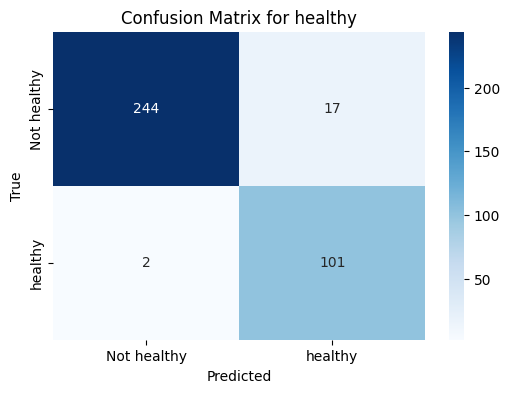


Metrics for class: multiple_diseases
  True Positives (TP): 15
  False Positives (FP): 25
  False Negatives (FN): 3
  True Negatives (TN): 321
  Precision: 0.3750
  Recall: 0.8333
  F1-score: 0.5172


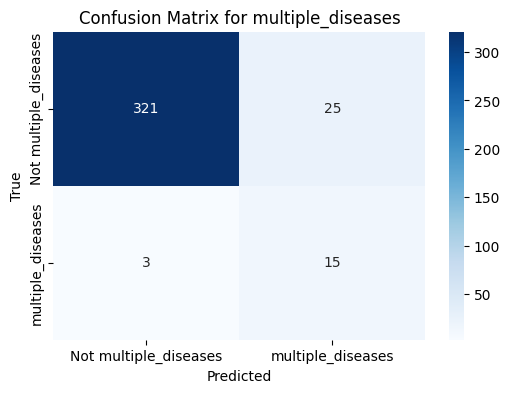


Metrics for class: rust
  True Positives (TP): 125
  False Positives (FP): 10
  False Negatives (FN): 0
  True Negatives (TN): 229
  Precision: 0.9259
  Recall: 1.0000
  F1-score: 0.9615


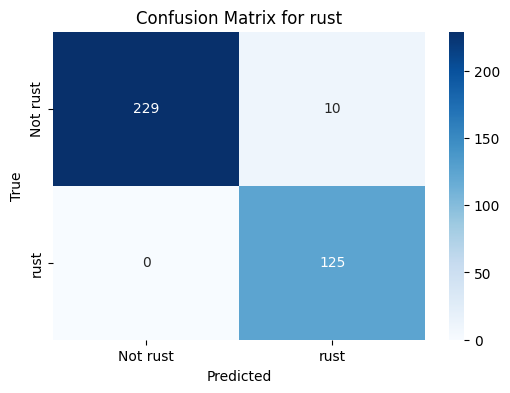


Metrics for class: scab
  True Positives (TP): 112
  False Positives (FP): 4
  False Negatives (FN): 6
  True Negatives (TN): 242
  Precision: 0.9655
  Recall: 0.9492
  F1-score: 0.9573


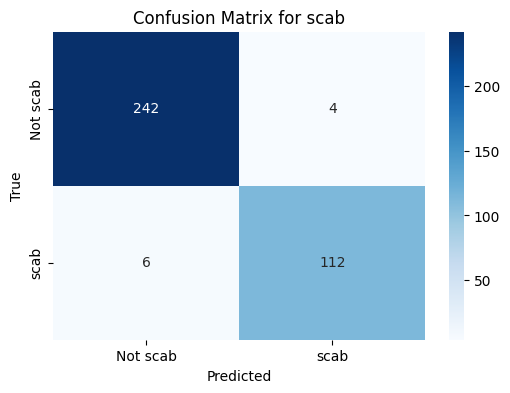

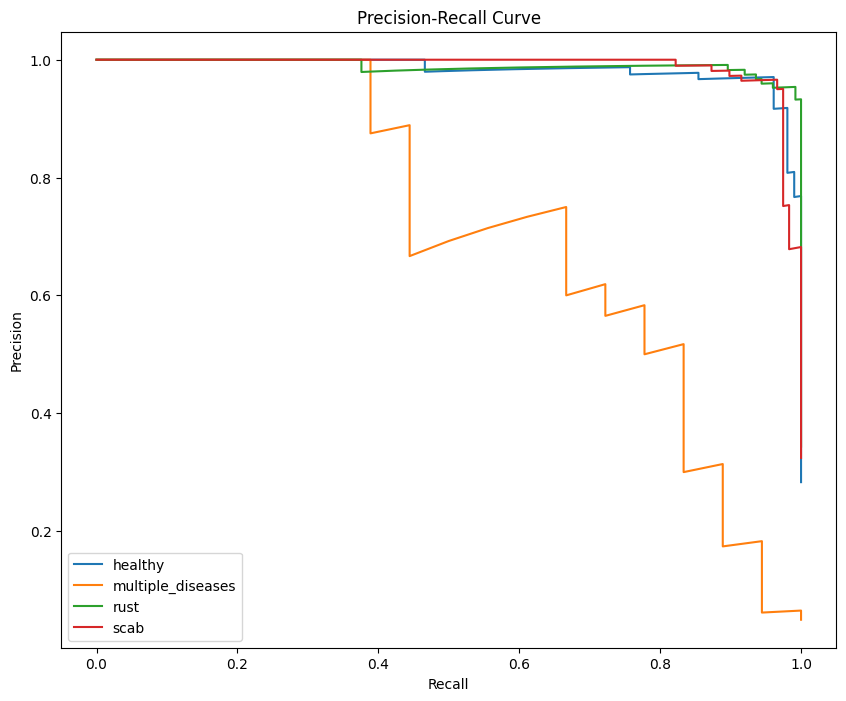

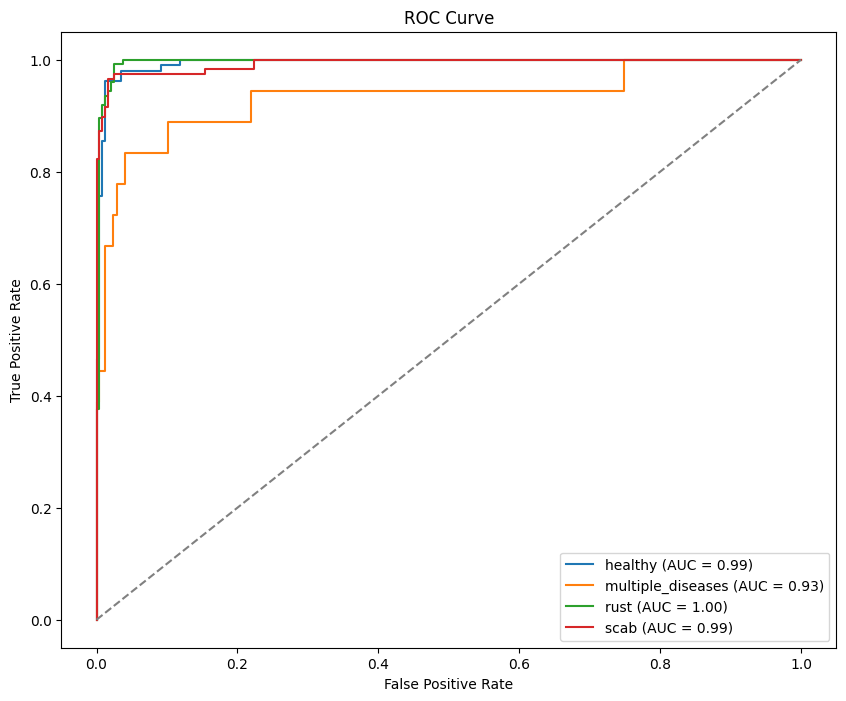


TESTING OPTIMIZER: Adam


----- Fold 1 / 5 (Optimizer: Adam) -----
Epoch 1/15
Train Loss: 1.1874 | Val Loss: 0.9788 | Val Acc: 0.4849
Epoch 2/15
Train Loss: 1.0486 | Val Loss: 0.8964 | Val Acc: 0.6096
Epoch 3/15
Train Loss: 0.9715 | Val Loss: 0.7775 | Val Acc: 0.6562
Epoch 4/15
Train Loss: 0.8741 | Val Loss: 0.6439 | Val Acc: 0.7219
Epoch 5/15
Train Loss: 0.8224 | Val Loss: 0.5386 | Val Acc: 0.8007
Epoch 6/15
Train Loss: 0.7621 | Val Loss: 0.4986 | Val Acc: 0.8144
Epoch 7/15
Train Loss: 0.7889 | Val Loss: 0.4527 | Val Acc: 0.8740
Epoch 8/15
Train Loss: 0.7355 | Val Loss: 0.4357 | Val Acc: 0.8870
Epoch 9/15
Train Loss: 0.6994 | Val Loss: 0.4117 | Val Acc: 0.8938
Epoch 10/15
Train Loss: 0.6855 | Val Loss: 0.3917 | Val Acc: 0.9082
Epoch 11/15
Train Loss: 0.6986 | Val Loss: 0.4011 | Val Acc: 0.9158
Epoch 12/15
Train Loss: 0.7533 | Val Loss: 0.4142 | Val Acc: 0.9048
Epoch 13/15
Train Loss: 0.6109 | Val Loss: 0.3840 | Val Acc: 0.9356
Epoch 14/15
Train Loss: 0.6576 | Val Loss: 0.3850 | Val A

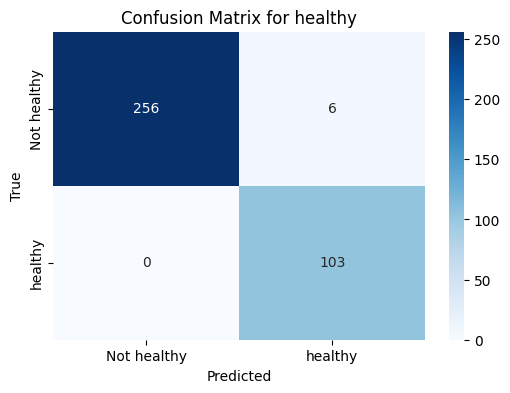


Metrics for class: multiple_diseases
  True Positives (TP): 11
  False Positives (FP): 36
  False Negatives (FN): 7
  True Negatives (TN): 311
  Precision: 0.2340
  Recall: 0.6111
  F1-score: 0.3385


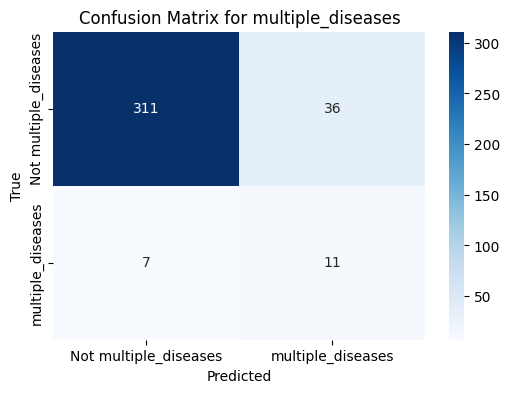


Metrics for class: rust
  True Positives (TP): 123
  False Positives (FP): 7
  False Negatives (FN): 2
  True Negatives (TN): 233
  Precision: 0.9462
  Recall: 0.9840
  F1-score: 0.9647


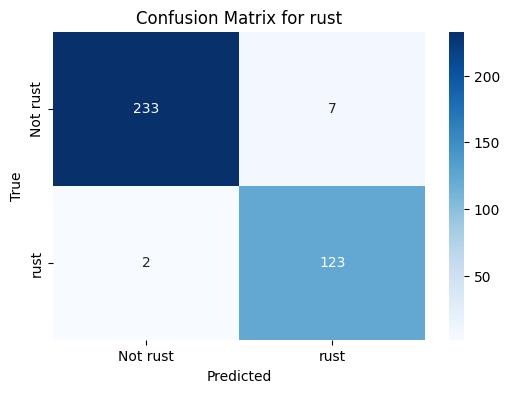


Metrics for class: scab
  True Positives (TP): 117
  False Positives (FP): 4
  False Negatives (FN): 2
  True Negatives (TN): 242
  Precision: 0.9669
  Recall: 0.9832
  F1-score: 0.9750


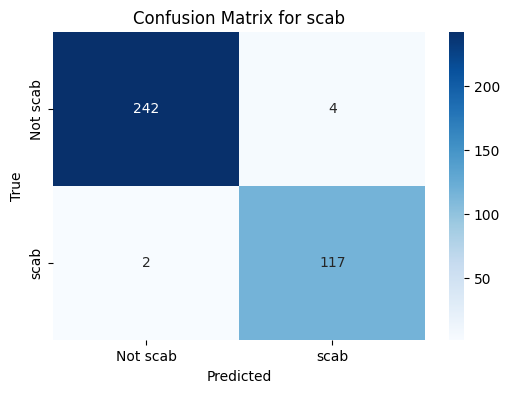

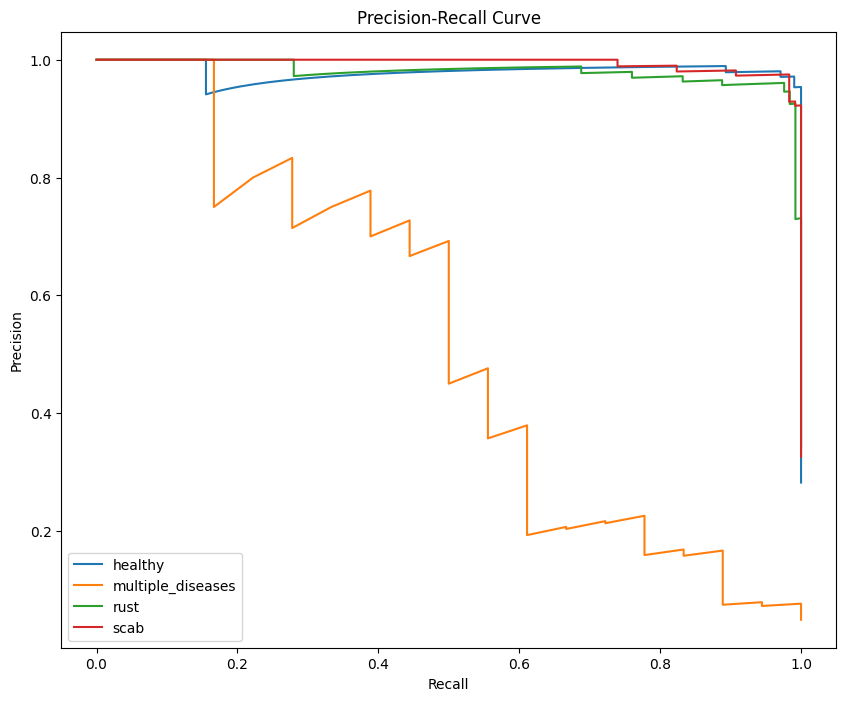

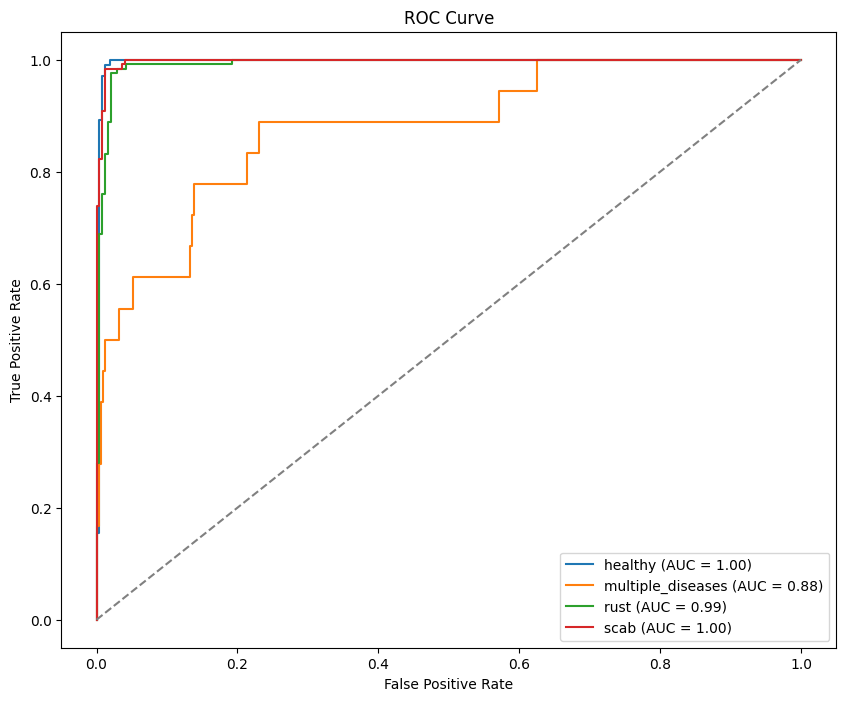


----- Fold 2 / 5 (Optimizer: Adam) -----
Epoch 1/15
Train Loss: 1.1375 | Val Loss: 0.9909 | Val Acc: 0.5433
Epoch 2/15
Train Loss: 1.0428 | Val Loss: 0.8729 | Val Acc: 0.6490
Epoch 3/15
Train Loss: 0.9483 | Val Loss: 0.7294 | Val Acc: 0.7081
Epoch 4/15
Train Loss: 0.8499 | Val Loss: 0.6116 | Val Acc: 0.7390
Epoch 5/15
Train Loss: 0.8046 | Val Loss: 0.5321 | Val Acc: 0.7912
Epoch 6/15
Train Loss: 0.7853 | Val Loss: 0.4840 | Val Acc: 0.8599
Epoch 7/15
Train Loss: 0.7114 | Val Loss: 0.4485 | Val Acc: 0.8729
Epoch 8/15
Train Loss: 0.7087 | Val Loss: 0.4190 | Val Acc: 0.8977
Epoch 9/15
Train Loss: 0.7361 | Val Loss: 0.4168 | Val Acc: 0.8970
Epoch 10/15
Train Loss: 0.6154 | Val Loss: 0.4009 | Val Acc: 0.9093
Epoch 11/15
Train Loss: 0.6417 | Val Loss: 0.3992 | Val Acc: 0.9066
Epoch 12/15
Train Loss: 0.6972 | Val Loss: 0.4039 | Val Acc: 0.9245
Epoch 13/15
Train Loss: 0.6385 | Val Loss: 0.4182 | Val Acc: 0.9155
Epoch 14/15
Train Loss: 0.7158 | Val Loss: 0.4218 | Val Acc: 0.9032
Epoch 15/15
Tra

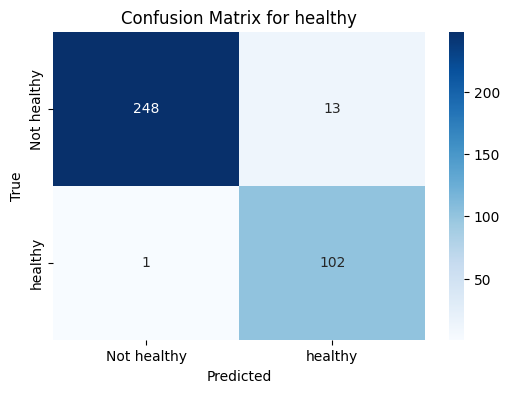


Metrics for class: multiple_diseases
  True Positives (TP): 8
  False Positives (FP): 17
  False Negatives (FN): 10
  True Negatives (TN): 329
  Precision: 0.3200
  Recall: 0.4444
  F1-score: 0.3721


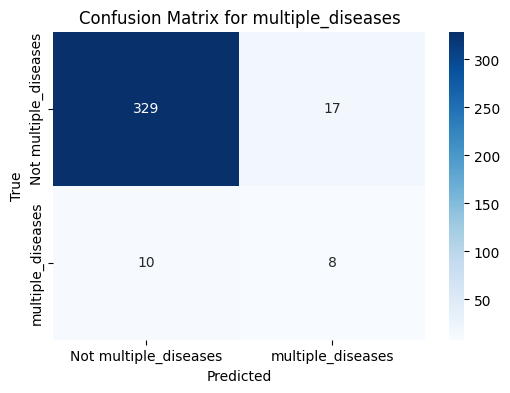


Metrics for class: rust
  True Positives (TP): 123
  False Positives (FP): 6
  False Negatives (FN): 1
  True Negatives (TN): 234
  Precision: 0.9535
  Recall: 0.9919
  F1-score: 0.9723


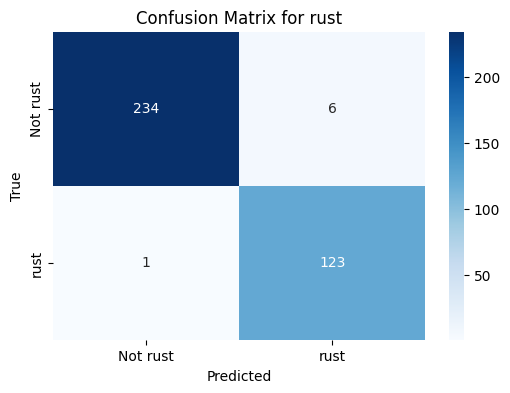


Metrics for class: scab
  True Positives (TP): 113
  False Positives (FP): 11
  False Negatives (FN): 6
  True Negatives (TN): 234
  Precision: 0.9113
  Recall: 0.9496
  F1-score: 0.9300


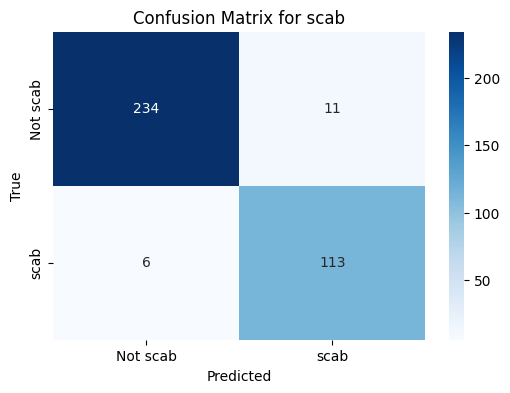

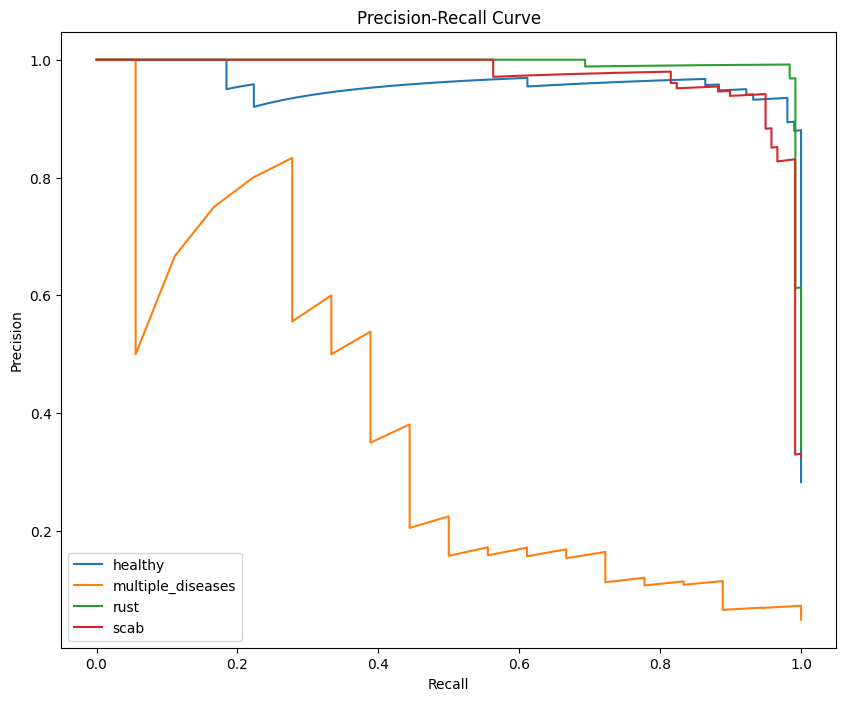

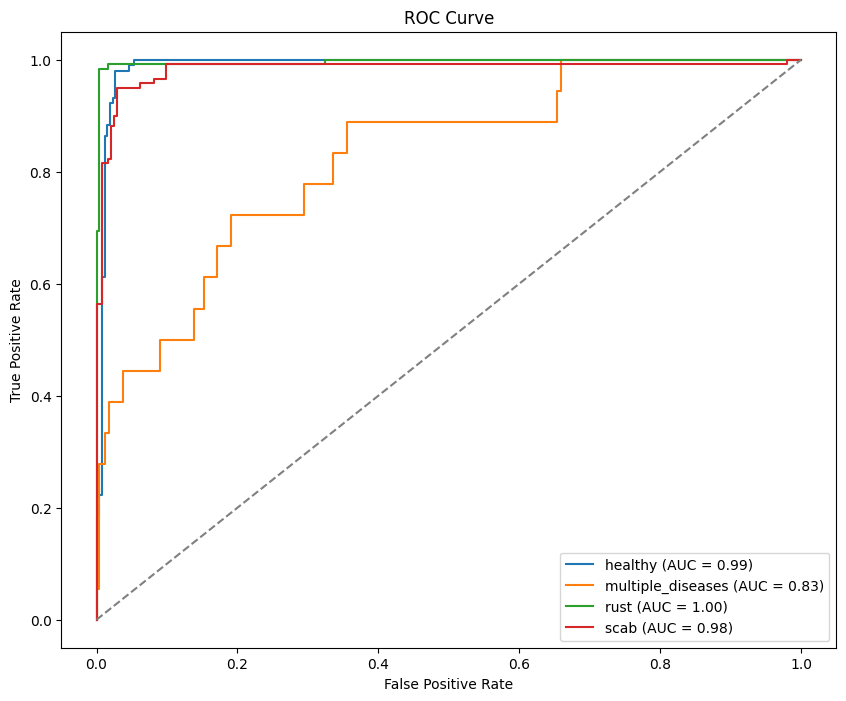


----- Fold 3 / 5 (Optimizer: Adam) -----
Epoch 1/15
Train Loss: 1.1391 | Val Loss: 0.9968 | Val Acc: 0.4547
Epoch 2/15
Train Loss: 1.0500 | Val Loss: 0.9048 | Val Acc: 0.6209
Epoch 3/15
Train Loss: 0.9471 | Val Loss: 0.7671 | Val Acc: 0.6820
Epoch 4/15
Train Loss: 0.8516 | Val Loss: 0.6460 | Val Acc: 0.7253
Epoch 5/15
Train Loss: 0.8117 | Val Loss: 0.5728 | Val Acc: 0.7610
Epoch 6/15
Train Loss: 0.7740 | Val Loss: 0.5066 | Val Acc: 0.8345
Epoch 7/15
Train Loss: 0.7230 | Val Loss: 0.4709 | Val Acc: 0.8503
Epoch 8/15
Train Loss: 0.7651 | Val Loss: 0.4525 | Val Acc: 0.8578
Epoch 9/15
Train Loss: 0.6806 | Val Loss: 0.4291 | Val Acc: 0.8867
Epoch 10/15
Train Loss: 0.6458 | Val Loss: 0.4023 | Val Acc: 0.8956
Epoch 11/15
Train Loss: 0.6516 | Val Loss: 0.3907 | Val Acc: 0.9114
Epoch 12/15
Train Loss: 0.6692 | Val Loss: 0.4006 | Val Acc: 0.9093
Epoch 13/15
Train Loss: 0.6175 | Val Loss: 0.3964 | Val Acc: 0.8997
Epoch 14/15
Train Loss: 0.6719 | Val Loss: 0.4062 | Val Acc: 0.9011
Epoch 15/15
Tra

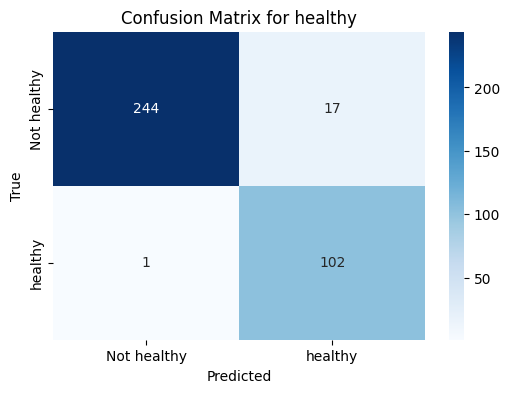


Metrics for class: multiple_diseases
  True Positives (TP): 13
  False Positives (FP): 15
  False Negatives (FN): 6
  True Negatives (TN): 330
  Precision: 0.4643
  Recall: 0.6842
  F1-score: 0.5532


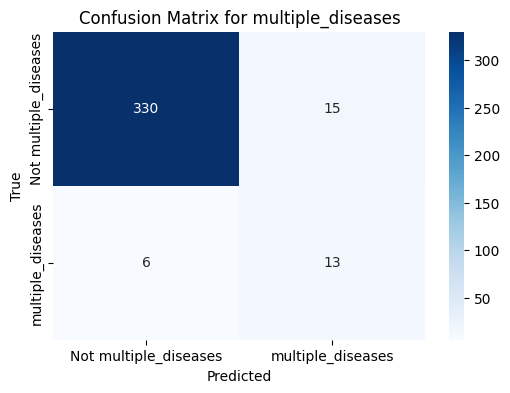


Metrics for class: rust
  True Positives (TP): 124
  False Positives (FP): 9
  False Negatives (FN): 0
  True Negatives (TN): 231
  Precision: 0.9323
  Recall: 1.0000
  F1-score: 0.9650


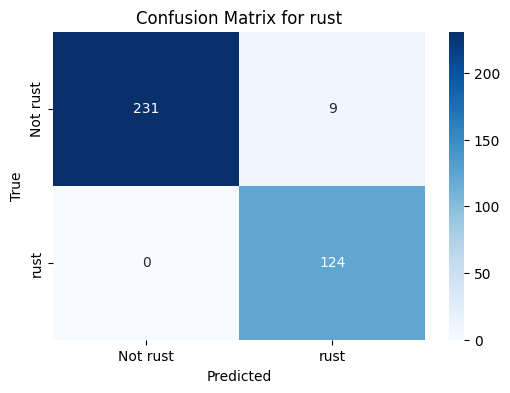


Metrics for class: scab
  True Positives (TP): 113
  False Positives (FP): 7
  False Negatives (FN): 5
  True Negatives (TN): 239
  Precision: 0.9417
  Recall: 0.9576
  F1-score: 0.9496


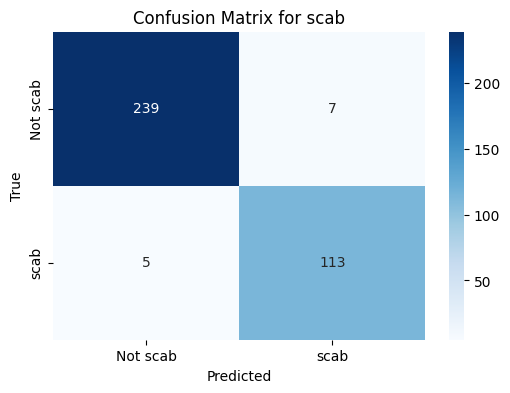

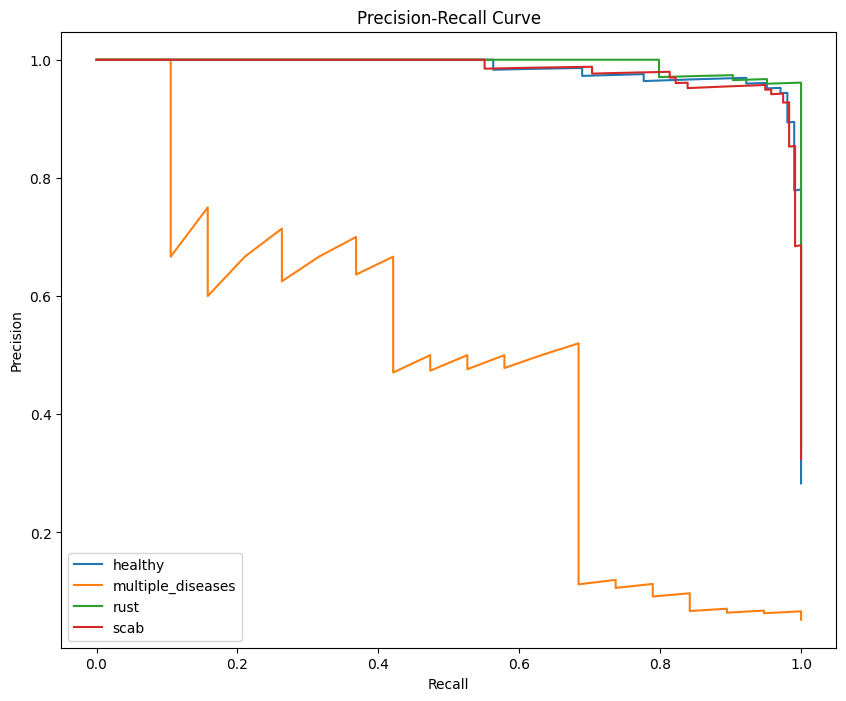

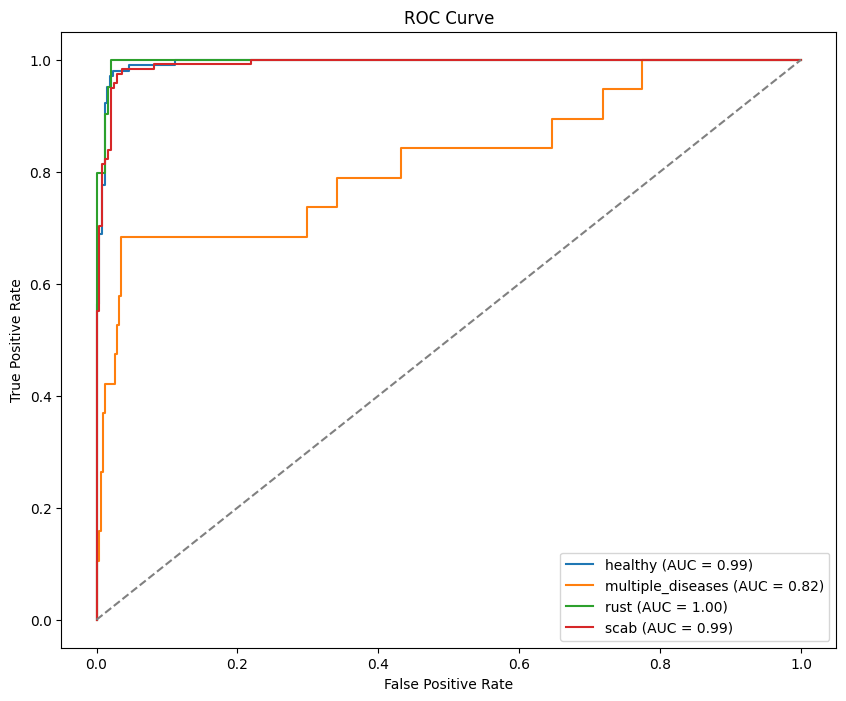


----- Fold 4 / 5 (Optimizer: Adam) -----
Epoch 1/15
Train Loss: 1.1311 | Val Loss: 0.9889 | Val Acc: 0.5227
Epoch 2/15
Train Loss: 1.0554 | Val Loss: 0.8948 | Val Acc: 0.5934
Epoch 3/15
Train Loss: 0.9703 | Val Loss: 0.7724 | Val Acc: 0.6525
Epoch 4/15
Train Loss: 0.8570 | Val Loss: 0.6379 | Val Acc: 0.7163
Epoch 5/15
Train Loss: 0.8178 | Val Loss: 0.5457 | Val Acc: 0.7740
Epoch 6/15
Train Loss: 0.7437 | Val Loss: 0.4612 | Val Acc: 0.8420
Epoch 7/15
Train Loss: 0.7188 | Val Loss: 0.4129 | Val Acc: 0.8942
Epoch 8/15
Train Loss: 0.7107 | Val Loss: 0.3993 | Val Acc: 0.8887
Epoch 9/15
Train Loss: 0.7348 | Val Loss: 0.3933 | Val Acc: 0.9128
Epoch 10/15
Train Loss: 0.6434 | Val Loss: 0.3725 | Val Acc: 0.8970
Epoch 11/15
Train Loss: 0.7209 | Val Loss: 0.3793 | Val Acc: 0.9169
Epoch 12/15
Train Loss: 0.6140 | Val Loss: 0.3847 | Val Acc: 0.9087
Epoch 13/15
Train Loss: 0.6642 | Val Loss: 0.3657 | Val Acc: 0.9073
Epoch 14/15
Train Loss: 0.7137 | Val Loss: 0.4103 | Val Acc: 0.9011
Epoch 15/15
Tra

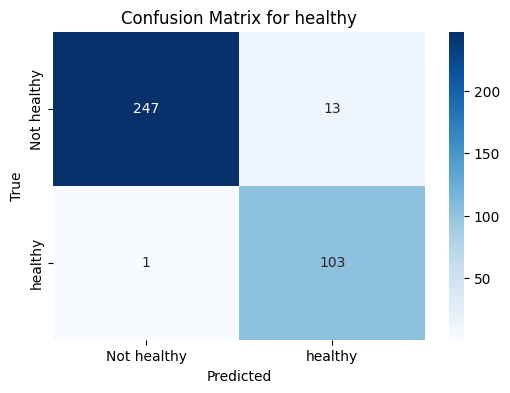


Metrics for class: multiple_diseases
  True Positives (TP): 13
  False Positives (FP): 24
  False Negatives (FN): 5
  True Negatives (TN): 322
  Precision: 0.3514
  Recall: 0.7222
  F1-score: 0.4727


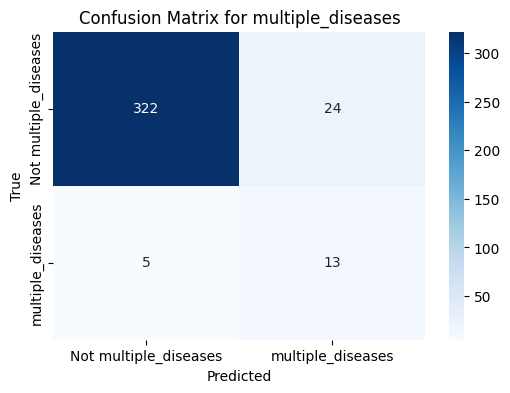


Metrics for class: rust
  True Positives (TP): 124
  False Positives (FP): 12
  False Negatives (FN): 0
  True Negatives (TN): 228
  Precision: 0.9118
  Recall: 1.0000
  F1-score: 0.9538


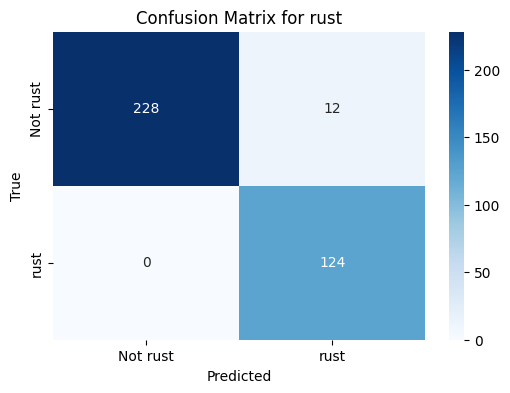


Metrics for class: scab
  True Positives (TP): 114
  False Positives (FP): 6
  False Negatives (FN): 4
  True Negatives (TN): 240
  Precision: 0.9500
  Recall: 0.9661
  F1-score: 0.9580


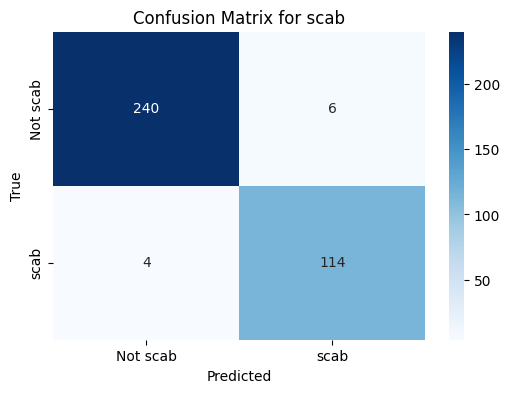

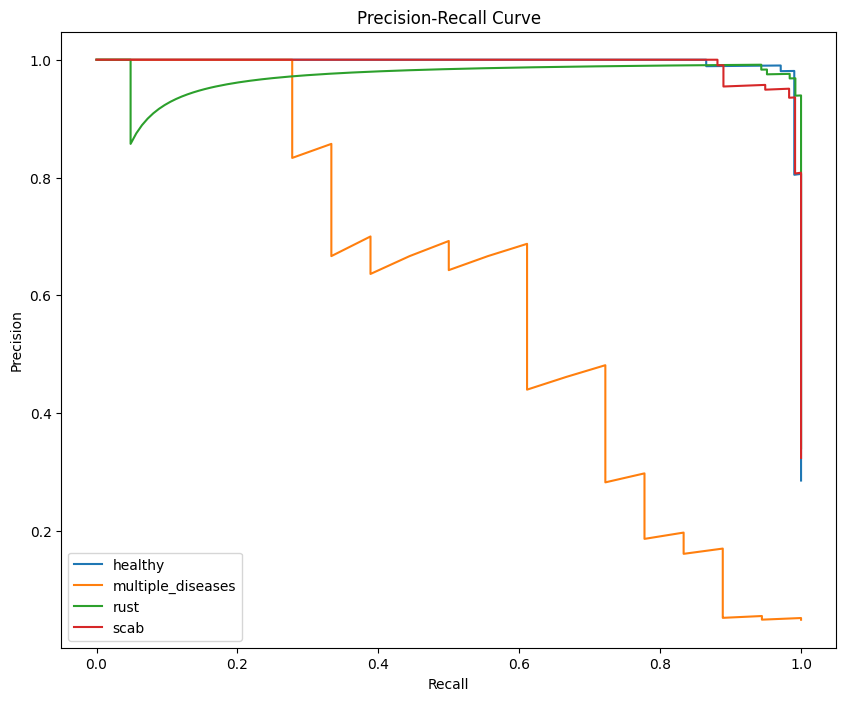

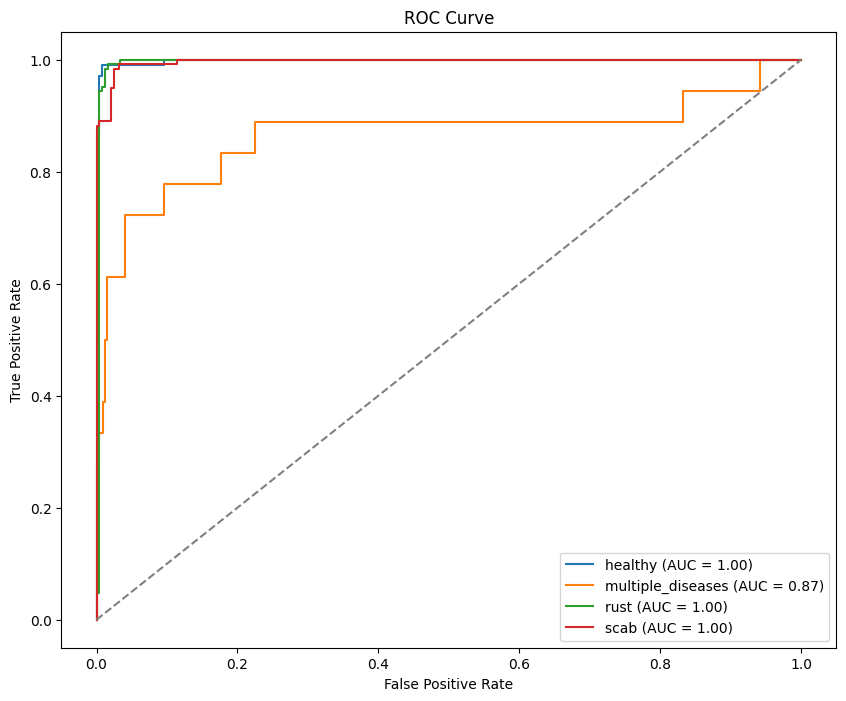


----- Fold 5 / 5 (Optimizer: Adam) -----
Epoch 1/15
Train Loss: 1.1622 | Val Loss: 0.9935 | Val Acc: 0.5419
Epoch 2/15
Train Loss: 1.0657 | Val Loss: 0.9087 | Val Acc: 0.6071
Epoch 3/15
Train Loss: 0.9681 | Val Loss: 0.7728 | Val Acc: 0.6971
Epoch 4/15
Train Loss: 0.8728 | Val Loss: 0.6526 | Val Acc: 0.7562
Epoch 5/15
Train Loss: 0.8296 | Val Loss: 0.5789 | Val Acc: 0.8043
Epoch 6/15
Train Loss: 0.7853 | Val Loss: 0.5304 | Val Acc: 0.8235
Epoch 7/15
Train Loss: 0.7687 | Val Loss: 0.4816 | Val Acc: 0.8716
Epoch 8/15
Train Loss: 0.7033 | Val Loss: 0.4502 | Val Acc: 0.8771
Epoch 9/15
Train Loss: 0.6809 | Val Loss: 0.4326 | Val Acc: 0.8942
Epoch 10/15
Train Loss: 0.7246 | Val Loss: 0.4201 | Val Acc: 0.9176
Epoch 11/15
Train Loss: 0.7195 | Val Loss: 0.4198 | Val Acc: 0.9038
Epoch 12/15
Train Loss: 0.6400 | Val Loss: 0.4033 | Val Acc: 0.9162
Epoch 13/15
Train Loss: 0.6706 | Val Loss: 0.4150 | Val Acc: 0.9293
Epoch 14/15
Train Loss: 0.6119 | Val Loss: 0.4005 | Val Acc: 0.9148
Epoch 15/15
Tra

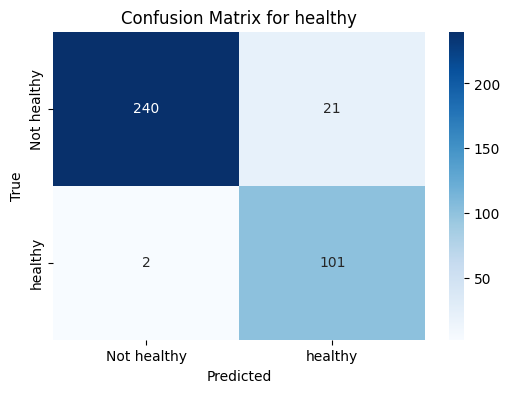


Metrics for class: multiple_diseases
  True Positives (TP): 11
  False Positives (FP): 20
  False Negatives (FN): 7
  True Negatives (TN): 326
  Precision: 0.3548
  Recall: 0.6111
  F1-score: 0.4490


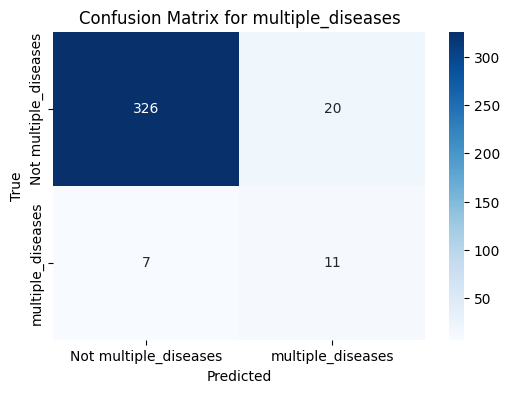


Metrics for class: rust
  True Positives (TP): 123
  False Positives (FP): 11
  False Negatives (FN): 2
  True Negatives (TN): 228
  Precision: 0.9179
  Recall: 0.9840
  F1-score: 0.9498


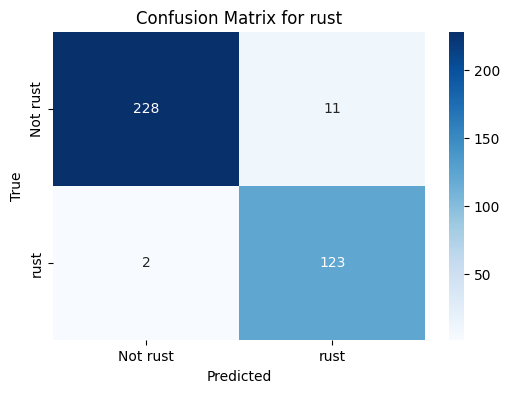


Metrics for class: scab
  True Positives (TP): 110
  False Positives (FP): 5
  False Negatives (FN): 8
  True Negatives (TN): 241
  Precision: 0.9565
  Recall: 0.9322
  F1-score: 0.9442


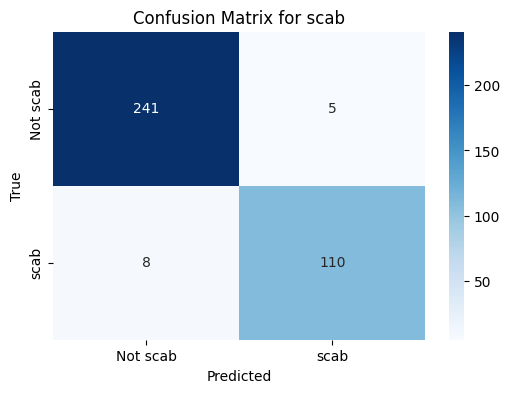

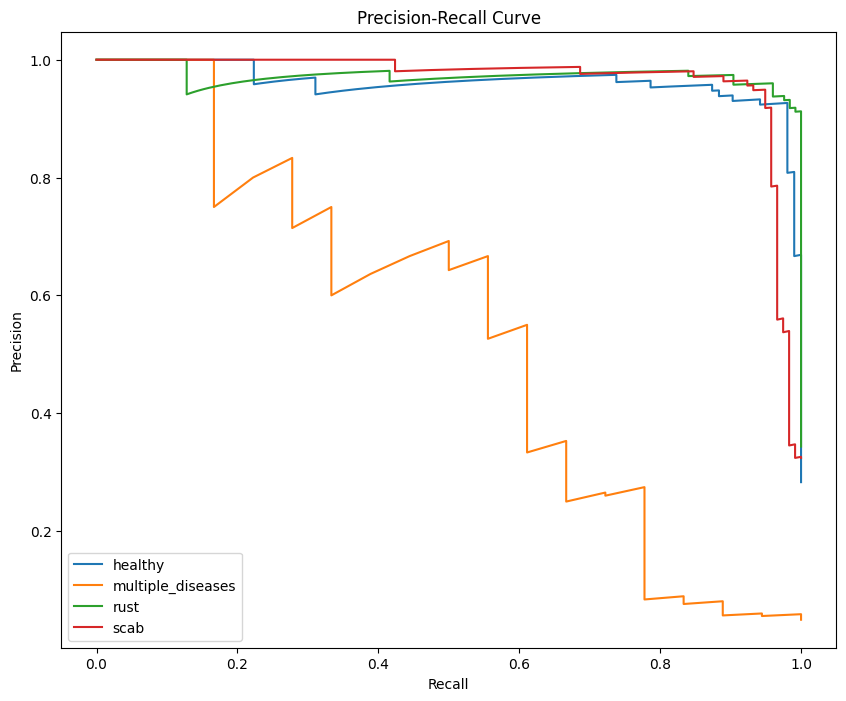

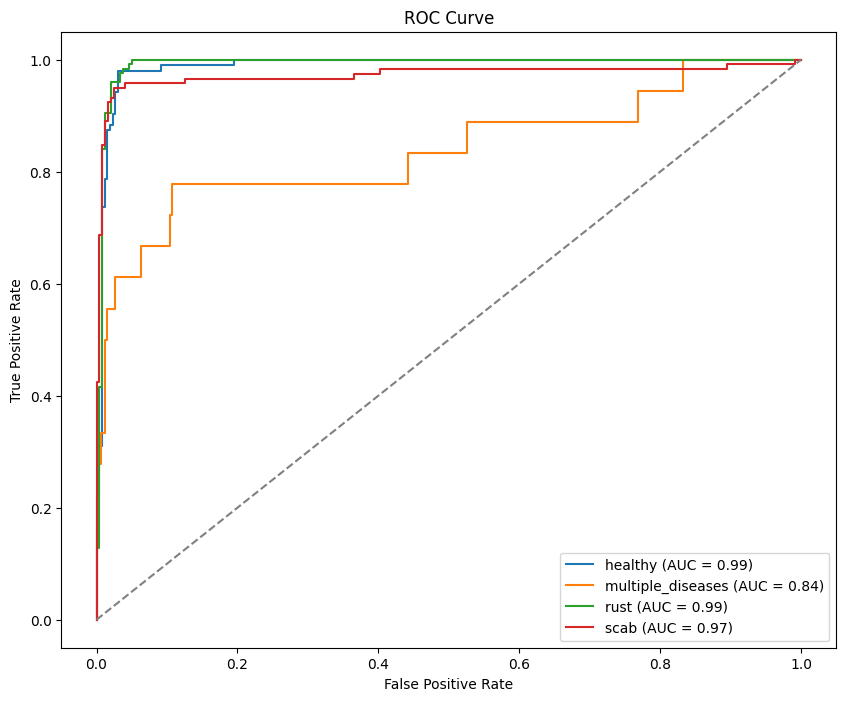


TESTING OPTIMIZER: AdamW


----- Fold 1 / 5 (Optimizer: AdamW) -----
Epoch 1/15
Train Loss: 1.1319 | Val Loss: 0.9700 | Val Acc: 0.5253
Epoch 2/15
Train Loss: 1.0452 | Val Loss: 0.8760 | Val Acc: 0.6342
Epoch 3/15
Train Loss: 0.9451 | Val Loss: 0.7438 | Val Acc: 0.6952
Epoch 4/15
Train Loss: 0.8810 | Val Loss: 0.6302 | Val Acc: 0.7349
Epoch 5/15
Train Loss: 0.7948 | Val Loss: 0.5454 | Val Acc: 0.7822
Epoch 6/15
Train Loss: 0.7692 | Val Loss: 0.4985 | Val Acc: 0.8370
Epoch 7/15
Train Loss: 0.6996 | Val Loss: 0.4414 | Val Acc: 0.8788
Epoch 8/15
Train Loss: 0.6777 | Val Loss: 0.4070 | Val Acc: 0.9075
Epoch 9/15
Train Loss: 0.6898 | Val Loss: 0.3970 | Val Acc: 0.9205
Epoch 10/15
Train Loss: 0.6719 | Val Loss: 0.3939 | Val Acc: 0.9027
Epoch 11/15
Train Loss: 0.6647 | Val Loss: 0.4016 | Val Acc: 0.9110
Epoch 12/15
Train Loss: 0.6562 | Val Loss: 0.3919 | Val Acc: 0.9281
Epoch 13/15
Train Loss: 0.6281 | Val Loss: 0.3966 | Val Acc: 0.9247
Epoch 14/15
Train Loss: 0.6764 | Val Loss: 0.4128 | Val

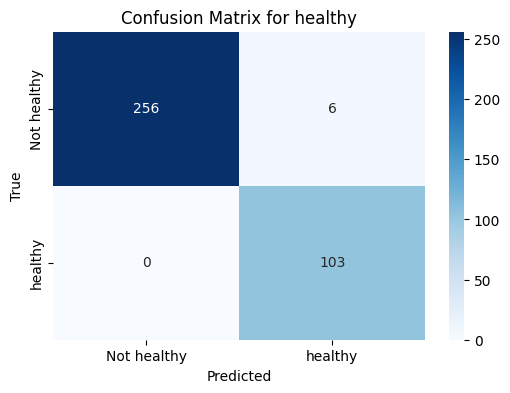


Metrics for class: multiple_diseases
  True Positives (TP): 8
  False Positives (FP): 13
  False Negatives (FN): 10
  True Negatives (TN): 334
  Precision: 0.3810
  Recall: 0.4444
  F1-score: 0.4103


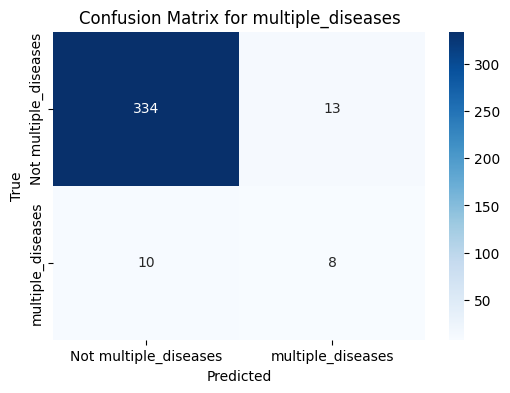


Metrics for class: rust
  True Positives (TP): 123
  False Positives (FP): 8
  False Negatives (FN): 2
  True Negatives (TN): 232
  Precision: 0.9389
  Recall: 0.9840
  F1-score: 0.9609


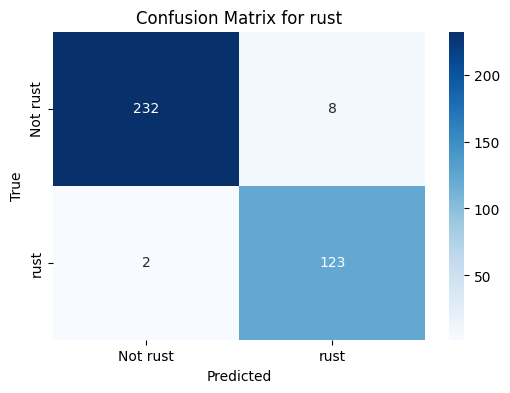


Metrics for class: scab
  True Positives (TP): 117
  False Positives (FP): 7
  False Negatives (FN): 2
  True Negatives (TN): 239
  Precision: 0.9435
  Recall: 0.9832
  F1-score: 0.9630


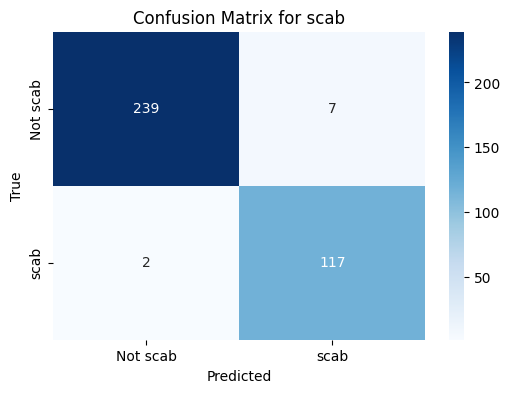

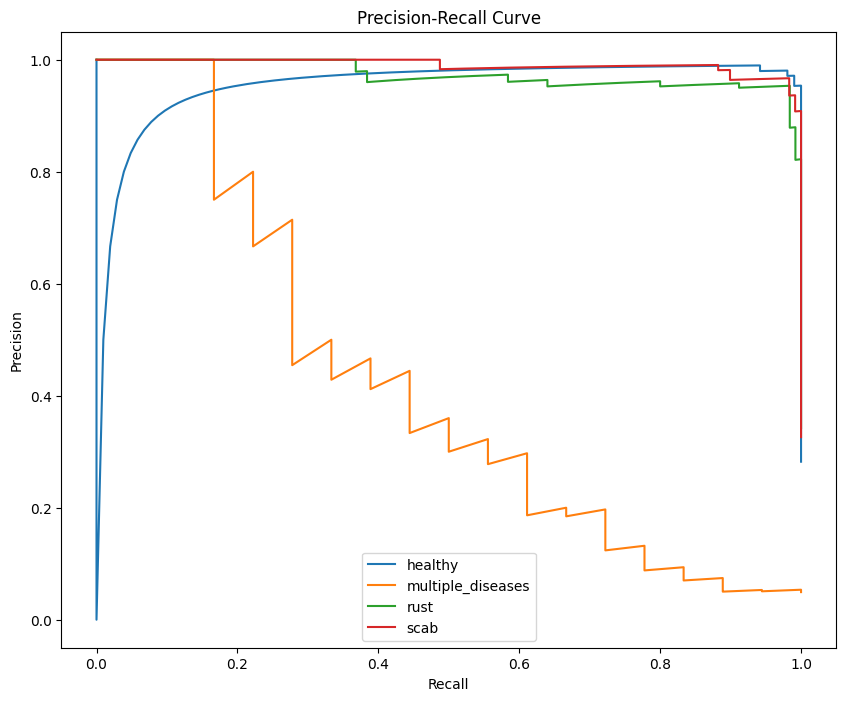

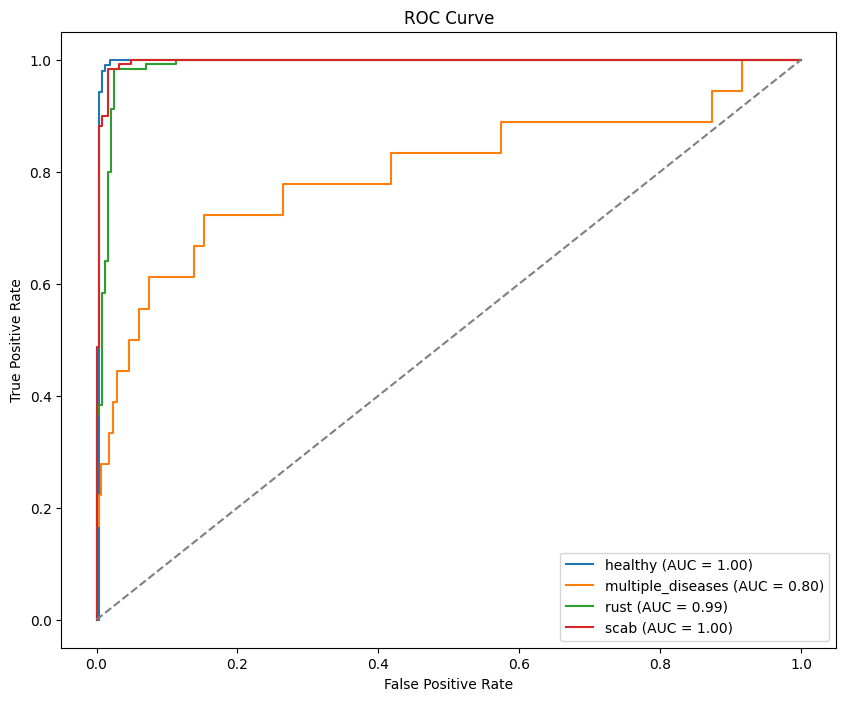


----- Fold 2 / 5 (Optimizer: AdamW) -----
Epoch 1/15
Train Loss: 1.1645 | Val Loss: 0.9716 | Val Acc: 0.5330
Epoch 2/15
Train Loss: 1.0580 | Val Loss: 0.8818 | Val Acc: 0.6202
Epoch 3/15
Train Loss: 0.9557 | Val Loss: 0.7479 | Val Acc: 0.6861
Epoch 4/15
Train Loss: 0.8477 | Val Loss: 0.6097 | Val Acc: 0.7582
Epoch 5/15
Train Loss: 0.8005 | Val Loss: 0.5222 | Val Acc: 0.8152
Epoch 6/15
Train Loss: 0.7423 | Val Loss: 0.4718 | Val Acc: 0.8386
Epoch 7/15
Train Loss: 0.7329 | Val Loss: 0.4329 | Val Acc: 0.8887
Epoch 8/15
Train Loss: 0.7300 | Val Loss: 0.4164 | Val Acc: 0.8922
Epoch 9/15
Train Loss: 0.7281 | Val Loss: 0.4159 | Val Acc: 0.8894
Epoch 10/15
Train Loss: 0.7120 | Val Loss: 0.4218 | Val Acc: 0.9032
Epoch 11/15
Train Loss: 0.6702 | Val Loss: 0.4227 | Val Acc: 0.8929
Epoch 12/15
Train Loss: 0.6273 | Val Loss: 0.3862 | Val Acc: 0.9245
Epoch 13/15
Train Loss: 0.6566 | Val Loss: 0.3977 | Val Acc: 0.9073
Epoch 14/15
Train Loss: 0.7360 | Val Loss: 0.4281 | Val Acc: 0.8942
Epoch 15/15
Tr

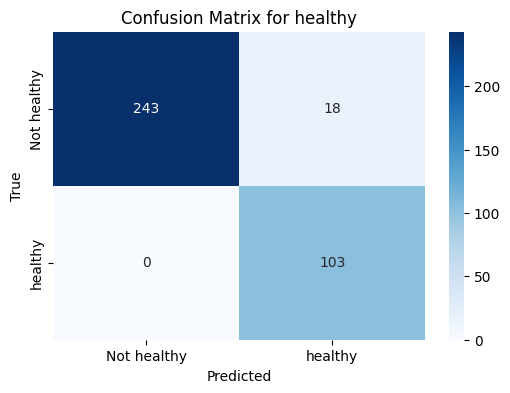


Metrics for class: multiple_diseases
  True Positives (TP): 10
  False Positives (FP): 21
  False Negatives (FN): 8
  True Negatives (TN): 325
  Precision: 0.3226
  Recall: 0.5556
  F1-score: 0.4082


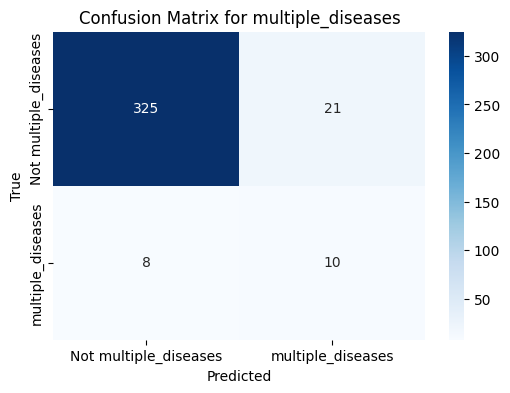


Metrics for class: rust
  True Positives (TP): 123
  False Positives (FP): 4
  False Negatives (FN): 1
  True Negatives (TN): 236
  Precision: 0.9685
  Recall: 0.9919
  F1-score: 0.9801


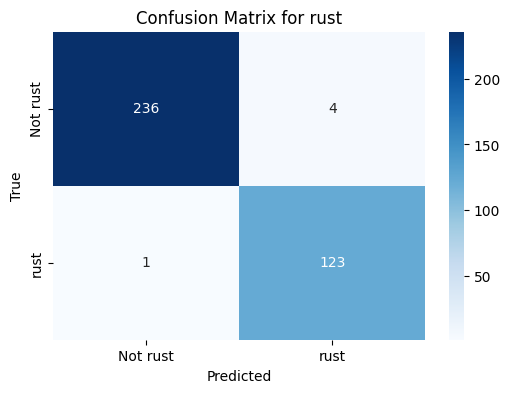


Metrics for class: scab
  True Positives (TP): 114
  False Positives (FP): 9
  False Negatives (FN): 5
  True Negatives (TN): 236
  Precision: 0.9268
  Recall: 0.9580
  F1-score: 0.9421


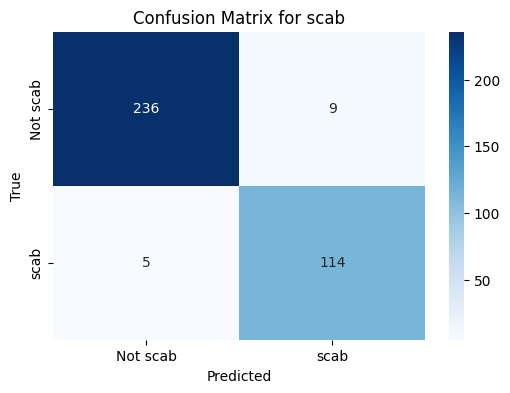

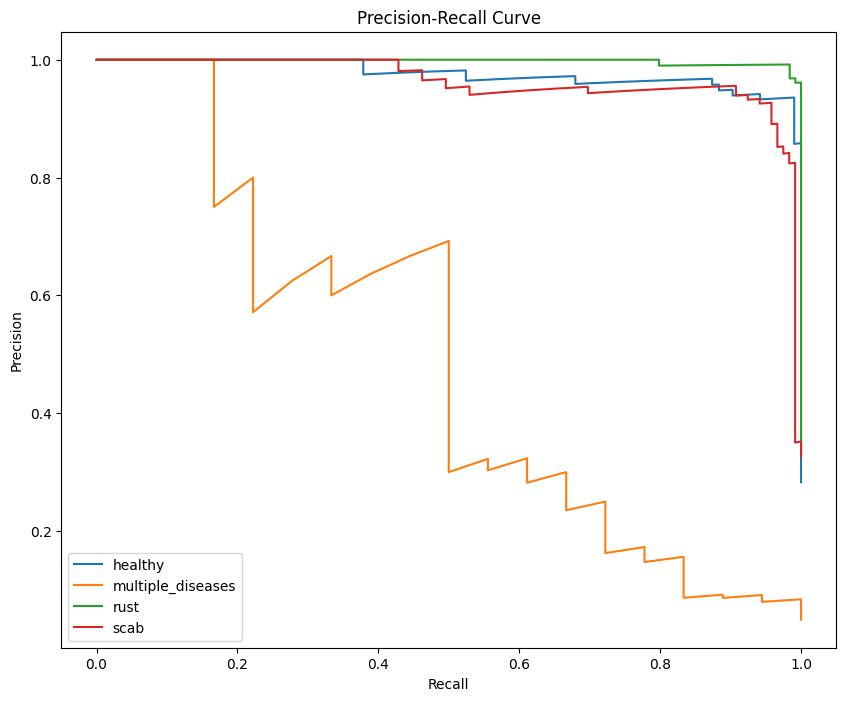

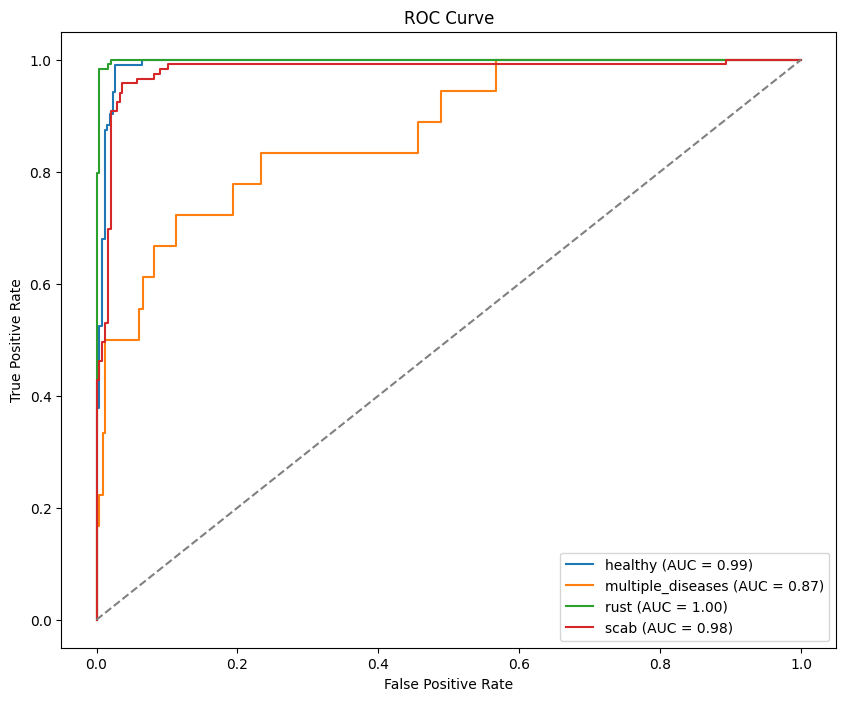


----- Fold 3 / 5 (Optimizer: AdamW) -----
Epoch 1/15
Train Loss: 1.1243 | Val Loss: 0.9815 | Val Acc: 0.5268
Epoch 2/15
Train Loss: 1.0219 | Val Loss: 0.8736 | Val Acc: 0.6511
Epoch 3/15
Train Loss: 0.9352 | Val Loss: 0.7410 | Val Acc: 0.7157
Epoch 4/15
Train Loss: 0.8714 | Val Loss: 0.6379 | Val Acc: 0.7981
Epoch 5/15
Train Loss: 0.8110 | Val Loss: 0.5586 | Val Acc: 0.8269
Epoch 6/15
Train Loss: 0.7843 | Val Loss: 0.4972 | Val Acc: 0.8510
Epoch 7/15
Train Loss: 0.7256 | Val Loss: 0.4529 | Val Acc: 0.8935
Epoch 8/15
Train Loss: 0.7233 | Val Loss: 0.4316 | Val Acc: 0.8723
Epoch 9/15
Train Loss: 0.7280 | Val Loss: 0.4224 | Val Acc: 0.9238
Epoch 10/15
Train Loss: 0.6801 | Val Loss: 0.4044 | Val Acc: 0.9128
Epoch 11/15
Train Loss: 0.6787 | Val Loss: 0.4110 | Val Acc: 0.9080
Epoch 12/15
Train Loss: 0.6199 | Val Loss: 0.3881 | Val Acc: 0.9217
Epoch 13/15
Train Loss: 0.6685 | Val Loss: 0.3923 | Val Acc: 0.9293
Epoch 14/15
Train Loss: 0.5906 | Val Loss: 0.3725 | Val Acc: 0.9272
Epoch 15/15
Tr

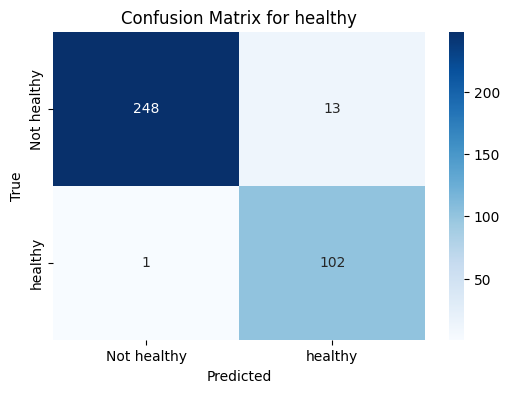


Metrics for class: multiple_diseases
  True Positives (TP): 11
  False Positives (FP): 20
  False Negatives (FN): 8
  True Negatives (TN): 325
  Precision: 0.3548
  Recall: 0.5789
  F1-score: 0.4400


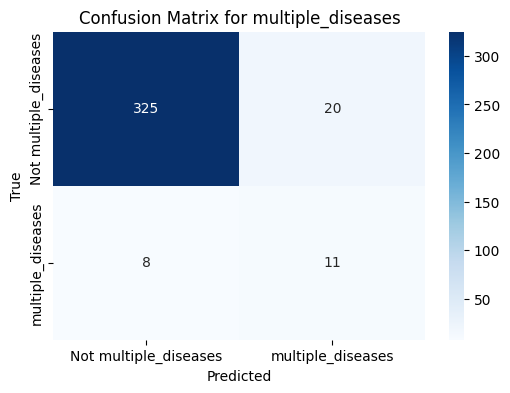


Metrics for class: rust
  True Positives (TP): 124
  False Positives (FP): 7
  False Negatives (FN): 0
  True Negatives (TN): 233
  Precision: 0.9466
  Recall: 1.0000
  F1-score: 0.9725


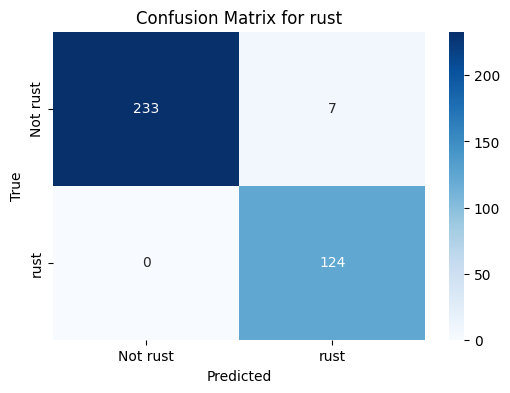


Metrics for class: scab
  True Positives (TP): 114
  False Positives (FP): 9
  False Negatives (FN): 4
  True Negatives (TN): 237
  Precision: 0.9268
  Recall: 0.9661
  F1-score: 0.9461


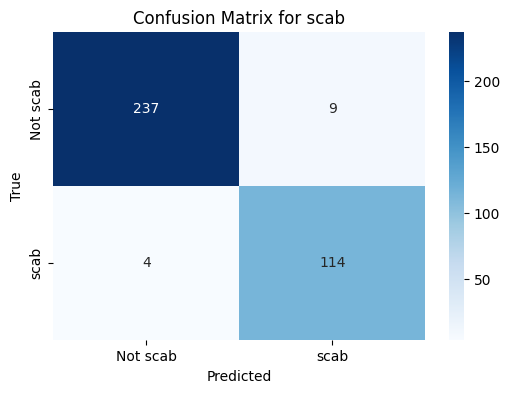

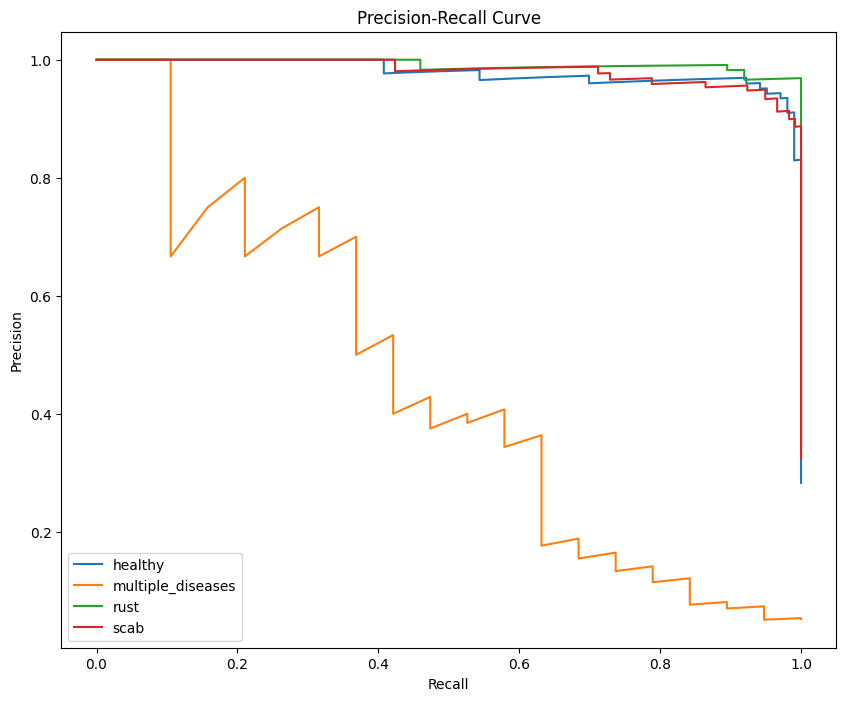

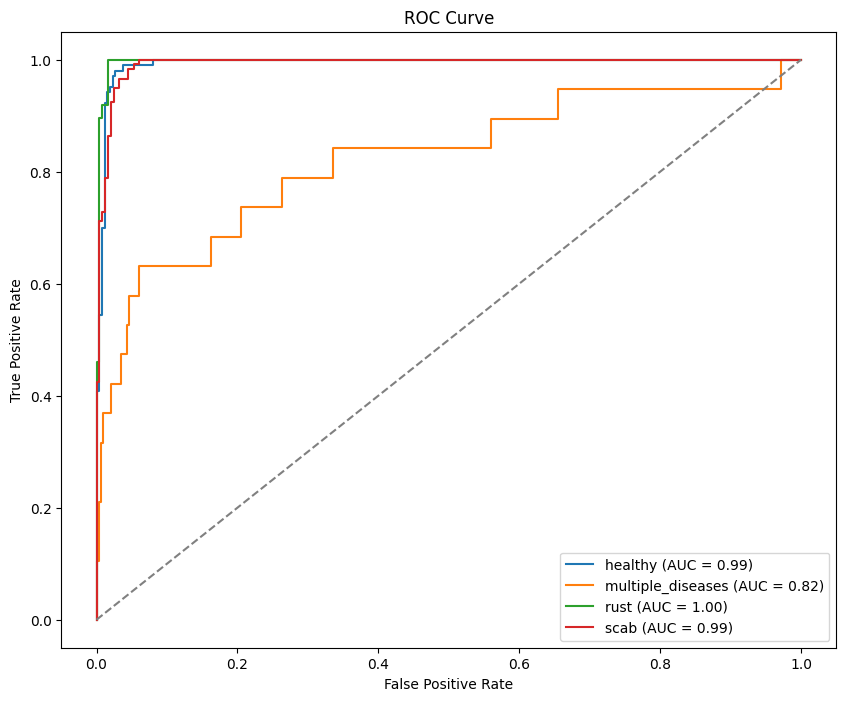


----- Fold 4 / 5 (Optimizer: AdamW) -----
Epoch 1/15
Train Loss: 1.1689 | Val Loss: 0.9771 | Val Acc: 0.4883
Epoch 2/15
Train Loss: 1.0496 | Val Loss: 0.8894 | Val Acc: 0.6037
Epoch 3/15
Train Loss: 0.9426 | Val Loss: 0.7473 | Val Acc: 0.6751
Epoch 4/15
Train Loss: 0.8594 | Val Loss: 0.6168 | Val Acc: 0.7582
Epoch 5/15
Train Loss: 0.7968 | Val Loss: 0.5278 | Val Acc: 0.7946
Epoch 6/15
Train Loss: 0.8048 | Val Loss: 0.4736 | Val Acc: 0.8503
Epoch 7/15
Train Loss: 0.7314 | Val Loss: 0.4264 | Val Acc: 0.8681
Epoch 8/15
Train Loss: 0.7595 | Val Loss: 0.4286 | Val Acc: 0.8846
Epoch 9/15
Train Loss: 0.7680 | Val Loss: 0.4140 | Val Acc: 0.8819
Epoch 10/15
Train Loss: 0.7114 | Val Loss: 0.4029 | Val Acc: 0.9052
Epoch 11/15
Train Loss: 0.6392 | Val Loss: 0.3791 | Val Acc: 0.9258
Epoch 12/15
Train Loss: 0.6877 | Val Loss: 0.3736 | Val Acc: 0.9210
Epoch 13/15
Train Loss: 0.6966 | Val Loss: 0.4094 | Val Acc: 0.8887
Epoch 14/15
Train Loss: 0.6580 | Val Loss: 0.3976 | Val Acc: 0.9155
Epoch 15/15
Tr

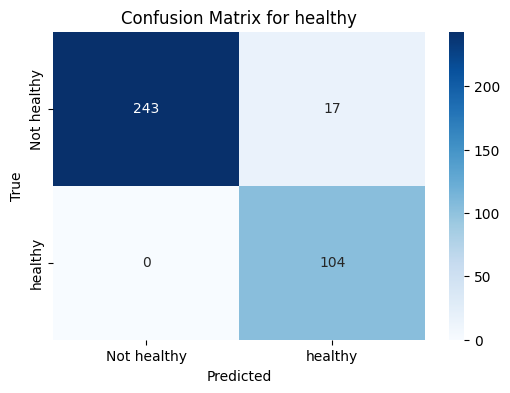


Metrics for class: multiple_diseases
  True Positives (TP): 13
  False Positives (FP): 27
  False Negatives (FN): 5
  True Negatives (TN): 319
  Precision: 0.3250
  Recall: 0.7222
  F1-score: 0.4483


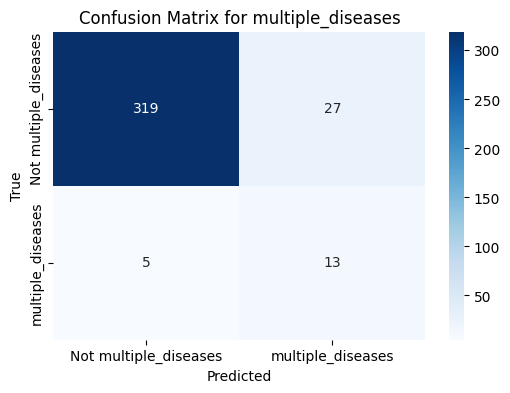


Metrics for class: rust
  True Positives (TP): 123
  False Positives (FP): 10
  False Negatives (FN): 1
  True Negatives (TN): 230
  Precision: 0.9248
  Recall: 0.9919
  F1-score: 0.9572


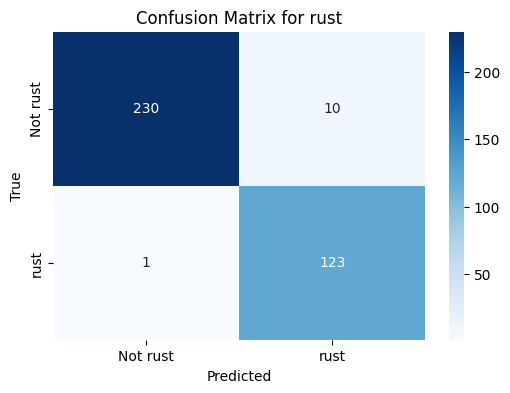


Metrics for class: scab
  True Positives (TP): 113
  False Positives (FP): 6
  False Negatives (FN): 5
  True Negatives (TN): 240
  Precision: 0.9496
  Recall: 0.9576
  F1-score: 0.9536


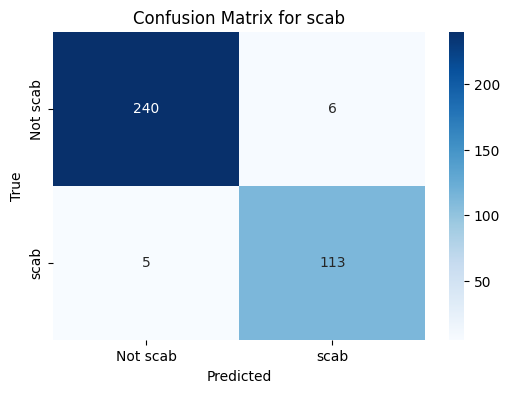

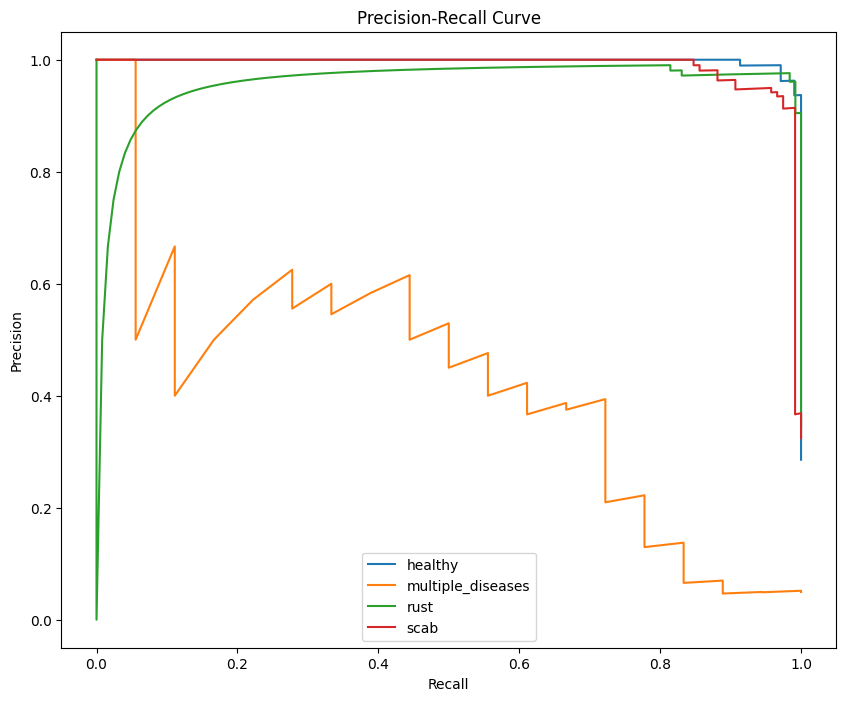

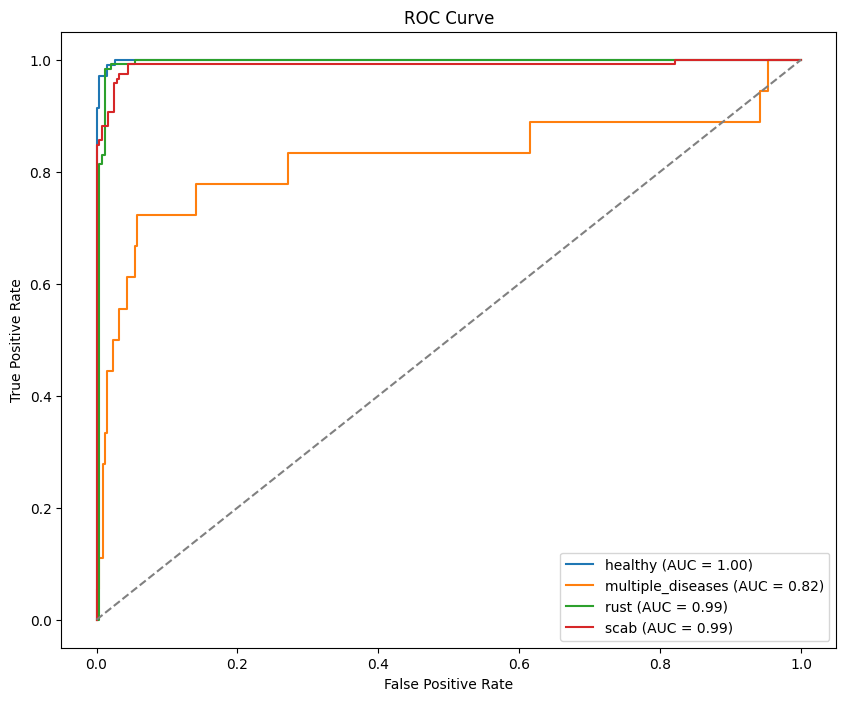


----- Fold 5 / 5 (Optimizer: AdamW) -----
Epoch 1/15
Train Loss: 1.1463 | Val Loss: 0.9834 | Val Acc: 0.5330
Epoch 2/15
Train Loss: 1.0487 | Val Loss: 0.9030 | Val Acc: 0.6010
Epoch 3/15
Train Loss: 0.9588 | Val Loss: 0.7781 | Val Acc: 0.6641
Epoch 4/15
Train Loss: 0.9145 | Val Loss: 0.6715 | Val Acc: 0.7246
Epoch 5/15
Train Loss: 0.8371 | Val Loss: 0.5921 | Val Acc: 0.7995
Epoch 6/15
Train Loss: 0.7616 | Val Loss: 0.5115 | Val Acc: 0.8029
Epoch 7/15
Train Loss: 0.7105 | Val Loss: 0.4591 | Val Acc: 0.8784
Epoch 8/15
Train Loss: 0.7122 | Val Loss: 0.4271 | Val Acc: 0.9011
Epoch 9/15
Train Loss: 0.7006 | Val Loss: 0.3971 | Val Acc: 0.9176
Epoch 10/15
Train Loss: 0.7090 | Val Loss: 0.4165 | Val Acc: 0.8956
Epoch 11/15
Train Loss: 0.6735 | Val Loss: 0.4010 | Val Acc: 0.9238
Epoch 12/15
Train Loss: 0.6074 | Val Loss: 0.3886 | Val Acc: 0.9320
Epoch 13/15
Train Loss: 0.7146 | Val Loss: 0.4124 | Val Acc: 0.9203
Epoch 14/15
Train Loss: 0.6614 | Val Loss: 0.4095 | Val Acc: 0.9375
Epoch 15/15
Tr

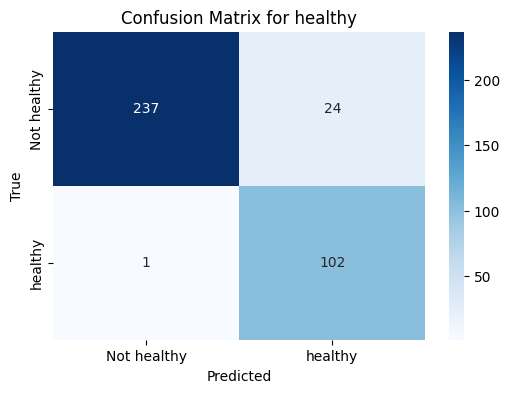


Metrics for class: multiple_diseases
  True Positives (TP): 13
  False Positives (FP): 23
  False Negatives (FN): 5
  True Negatives (TN): 323
  Precision: 0.3611
  Recall: 0.7222
  F1-score: 0.4815


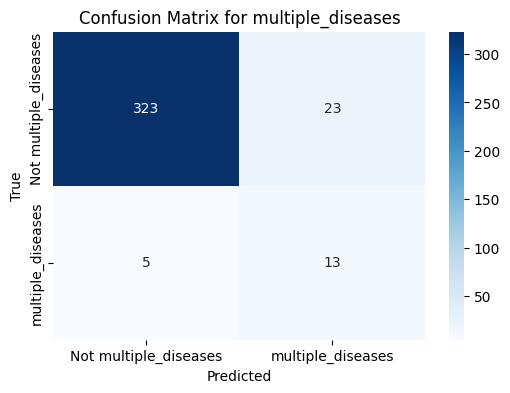


Metrics for class: rust
  True Positives (TP): 125
  False Positives (FP): 14
  False Negatives (FN): 0
  True Negatives (TN): 225
  Precision: 0.8993
  Recall: 1.0000
  F1-score: 0.9470


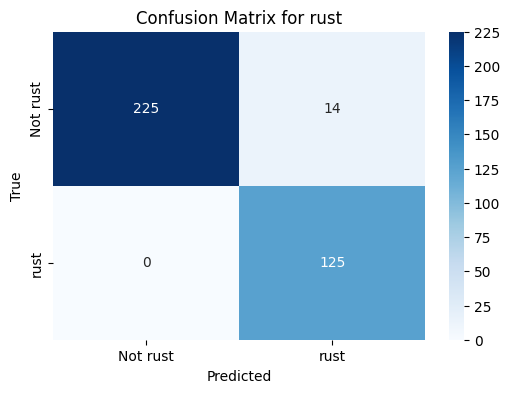


Metrics for class: scab
  True Positives (TP): 109
  False Positives (FP): 3
  False Negatives (FN): 9
  True Negatives (TN): 243
  Precision: 0.9732
  Recall: 0.9237
  F1-score: 0.9478


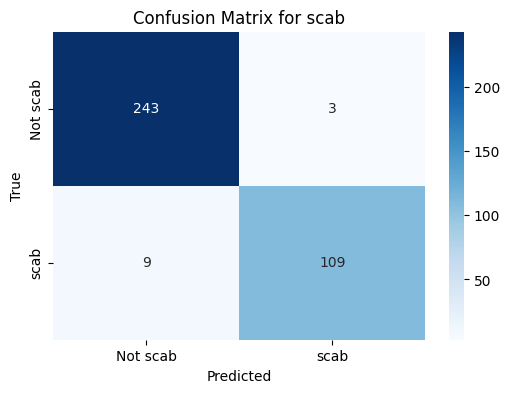

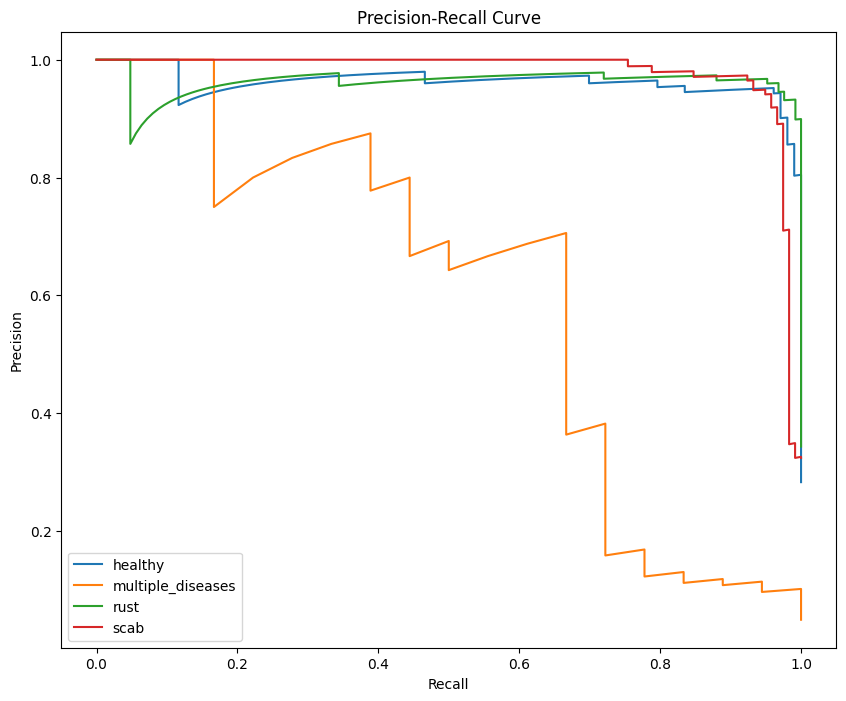

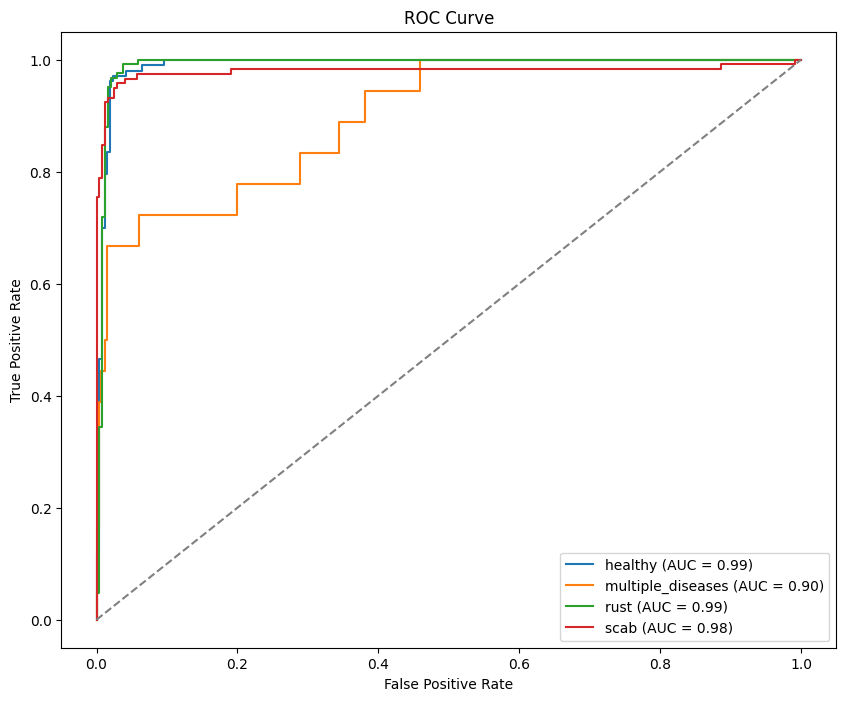


============== OPTIMIZER COMPARISON ==============

Optimizer: SGD
  Mean Accuracy:  0.9231 ± 0.0144
  Mean Macro F1:  0.8107 ± 0.0173

Optimizer: Adam
  Mean Accuracy:  0.9139 ± 0.0083
  Mean Macro F1:  0.8204 ± 0.0159

Optimizer: AdamW
  Mean Accuracy:  0.9316 ± 0.0115
  Mean Macro F1:  0.8200 ± 0.0049

Optimizer Comparison Table:
       mean_accuracy  std_accuracy  mean_macro_f1  std_macro_f1
SGD         0.923124      0.014413       0.810664      0.017322
Adam        0.913912      0.008321       0.820424      0.015950
AdamW       0.931619      0.011480       0.820044      0.004939


In [ ]:
from sklearn.model_selection import StratifiedKFold
from torchvision import models, transforms
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import f1_score, classification_report
from copy import deepcopy
import numpy as np
import torch
import os

# Data augmentation for better generalization
# V8->V9 lessened the strength of augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Apply validation transforms to test dataset
test_data.transform = val_transform

# Create test DataLoader
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Model initialization
# Upgraded to resnet34 from resnet18 because was hitting limits of model capacity
def initialize_model():
    model = models.resnet34()
    # Construct the full path to the .pth file inside the downloaded directory
    weights_file_path = os.path.join(rnapark_resnet34_b627a593_pth_path, 'resnet34-b627a593.pth')
    state_dict = torch.load(weights_file_path, map_location="cpu")
    model.load_state_dict(state_dict)
    # Added dropout layer
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(model.fc.in_features, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(512, 4)  # Output layer
    )
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare labels and class weights
y_single = [np.argmax(sample[1]) for sample in train_data]  # For stratification
all_labels = torch.stack([torch.tensor(sample[1], dtype=torch.float32) for sample in train_data])
pos = all_labels.sum(dim=0)
neg = all_labels.shape[0] - pos
pos_weight = (neg / (pos + 1e-5)).to(device)

optimizers_to_test = {
    "SGD": lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1e-6),
    "Adam": lambda params: torch.optim.Adam(params, lr=1e-4, weight_decay=1e-6),
    "AdamW": lambda params: torch.optim.AdamW(params, lr=2e-4, weight_decay=1e-6)
}

optimizer_results = {}  # store results for the summary table


# k-fold over each optimizer
for opt_name, opt_builder in optimizers_to_test.items():
    print(f"\n========================")
    print(f"TESTING OPTIMIZER: {opt_name}")
    print(f"========================\n")

    fold_accuracies = []
    fold_macro_f1 = []
    fold_test_predictions = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, y_single)):
        print(f"\n----- Fold {fold + 1} / 5 (Optimizer: {opt_name}) -----")

        # build datasets
        train_dataset = deepcopy(train_data)
        val_dataset = deepcopy(train_data)
        train_dataset.transform = train_transform
        val_dataset.transform = val_transform

        train_loader_fold = torch.utils.data.DataLoader(
            torch.utils.data.Subset(train_dataset, train_idx), batch_size=64, shuffle=True
        )
        val_loader_fold = torch.utils.data.DataLoader(
            torch.utils.data.Subset(val_dataset, val_idx), batch_size=64, shuffle=False
        )

        val_subset = torch.utils.data.Subset(val_dataset, val_idx)

        model = initialize_model().to(device)
        optimizer = opt_builder(model.parameters())   # optimizer CHANGES per loop
        loss_fn = BCEWithLogitsLoss(pos_weight=pos_weight, reduction="mean")

        if opt_name in ["AdamW", "Adam"]:
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=2e-4,
                epochs=15,
                steps_per_epoch=len(train_loader_fold),
                pct_start=0.2,
                div_factor=10,
                final_div_factor=100
            )
        else:
            scheduler = None  # SGD works fine without OneCycleLR

        # training
        best_val_loss = float("inf")
        best_val_accuracy = 0
        patience = 5
        epochs_no_improve = 0

        for epoch in range(15):
            print(f"Epoch {epoch+1}/15")

            train_loss = train_loop(train_loader_fold, model, loss_fn, optimizer, device)
            val_loss, val_acc = evaluate_model(val_loader_fold, model, loss_fn, device)

            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_val_accuracy = val_acc
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print("Early stopping triggered.")
                    break

            if scheduler is not None:
                scheduler.step()

        thresholds = [0.5, 0.6, 0.4, 0.45]
        y_true, y_probs = predict_loop(val_loader_fold, model, device)
        y_pred = (y_probs >= torch.tensor(thresholds)).int().numpy()
        y_true_np = y_true.numpy()
        y_probs_np = y_probs.numpy()

        # Metrics
        print("\nClassification Report:")
        print(classification_report(
            y_true.numpy(), y_pred,
            target_names=['healthy', 'multiple_diseases', 'rust', 'scab']
        ))

        macro_f1 = f1_score(y_true.numpy(), y_pred, average="macro")
        fold_macro_f1.append(macro_f1)
        fold_accuracies.append(best_val_accuracy)

        print(f"Macro F1: {macro_f1:.4f}")

        plot_confusion_matrix(y_true_np, y_pred, ['healthy','multiple_diseases','rust','scab'])
        plot_precision_recall_curve(y_true_np, y_probs_np, ['healthy','multiple_diseases','rust','scab'])
        plot_roc_curve(y_true_np, y_probs_np, ['healthy','multiple_diseases','rust','scab'])

        fold_test_predictions.append(
            predict_test_loop(test_loader, model, device)
        )

    # Aggregate optimizer results
    optimizer_results[opt_name] = {
        "mean_accuracy": float(np.mean(fold_accuracies)),
        "std_accuracy": float(np.std(fold_accuracies)),
        "mean_macro_f1": float(np.mean(fold_macro_f1)),
        "std_macro_f1": float(np.std(fold_macro_f1))
    }

print("\n============== OPTIMIZER COMPARISON ==============")
for opt, metrics in optimizer_results.items():
    print(f"\nOptimizer: {opt}")
    print(f"  Mean Accuracy:  {metrics['mean_accuracy']:.4f} \u00b1 {metrics['std_accuracy']:.4f}")
    print(f"  Mean Macro F1:  {metrics['mean_macro_f1']:.4f} \u00b1 {metrics['std_macro_f1']:.4f}")


# OPTIONAL: into DataFrame
import pandas as pd
df = pd.DataFrame.from_dict(optimizer_results, orient="index")
print("\nOptimizer Comparison Table:")
print(df)

## Summary/Interpretation of metrics:

### Optimizer Performance Summary
| Optimizer | Mean Accuracy | Mean Macro F1 |
|-----------|---------------|---------------|
| SGD       | 0.9231 ± 0.0144 | 0.8107 ± 0.0173 |
| Adam      | 0.9139 ± 0.0083 | 0.8204 ± 0.0159 |
| AdamW     | 0.9316 ± 0.0115 | 0.8200 ± 0.0049 |

### Comparison Table

| Optimizer | Mean Accuracy | Std Accuracy | Mean Macro F1 | Std Macro F1 |
|-----------|---------------|--------------|---------------|--------------|
| SGD       | 0.9231        | 0.0144       | 0.8107        | 0.0173       |
| Adam      | 0.9139        | 0.0083       | 0.8204        | 0.0159       |
| AdamW     | 0.9316        | 0.0115       | 0.8200        | 0.0049       |


AdamW achieved the highest mean validation accuracy (0.9316) and the lowest variance, indicating strong generalization and stability across folds. Although Adam showed the highest macro-F1 score (0.8204), the difference relative to AdamW (0.8200) was negligible, suggesting similar class-wise performance. SGD performed reasonably well but showed the lowest macro-F1 and the highest variance, indicating less consistent training dynamics and weaker handling of minority classes. Overall, AdamW provided the best balance of accuracy, class-wise performance, and consistency, making it the most effective optimizer for this multi-label classification task.
